# Imports et setup technique

In [1]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from pathlib import Path
import numpy as np
import seaborn as sns
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.models.annotations import BoxAnnotation
from bokeh.models.widgets import DateRangeSlider, Select, DatePicker
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

client  V groupecompte                           nom postalcode seg1  \
15663   83578  A         ZCLT  CENTRE HOSPITALIER STE MARIE      12032   Z3   
21122  270828  A         ZHIE                    BEST HOTEL      75010  NaN   
3763    72193  A         ZCLT          LYCEE RAOUL VADEPIED      53602   Z3   
497     10611  A         ZHIE                    BRIT'HOTEL      35132  NaN   
4089    25363  A         ZCLT       RESTAURANT LE THILLOTIN      88160   Z3   

      seg2 seg3 seg4  cat  ... grpclt5  agence condexp  pricetype  \
15663   Z4   ZI   ZD   ZM  ...     031    1TOU      ST         T2   
21122  NaN  NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN   
3763    Z4   ZI   ZB   ZL  ...     L31    2MAY      ST         T2   
497    NaN  NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN   
4089    Z5   ZK   ZG   ZS  ...     051    1NAN      ST         T1   

      relationtype pilcom  hier4  hier3   hier2   hier1  
15663          NDI    RGL  10897  10898   55584   79717  
21122          NaN    NaN    NaN    NaN     NaN     NaN  
3763           NDI    RGL  10806  10807  197994  197997  
497            NaN    NaN    NaN    NaN     NaN     NaN  
4089           NDI    RGL    NaN    NaN     NaN     NaN  

[5 rows x 31 columns]

In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                             nom postalcode  \
orgacom client                                                                  
2BRE    0000176724  A         ZCLT             HOMARD BLEU DE CAEN      14123   
1SOU    CR00038422  A         ZCRI                      GROUPE SDW        NaN   
2BRE    0000218432  A         ZCRC    FACULTE DES METIERS KER LANN      35170   
1SOU    0000160048  A         ZFAC  LE PETIT ITALIEN KIOSQUE PIZZA      64140   
2BRE    0000167830  A         ZCHN          REST SCOLAIRE DE PLELO      22170   

                   seg1 seg2 seg3 seg4  cat sscat  ...  grpclt5 agence  \
orgacom client                                     ...                   
2BRE    0000176724   Z1   Z3   ZG   ZV   ZK   Z05  ...      L51   2CAL   
1SOU    CR00038422  NaN  NaN  NaN  NaN  NaN   NaN  ...      NaN    NaN   
2BRE    0000218432   Z3   Z4   ZI   ZB   ZL   Z12  ...      L31   2REN   
1SOU    0000160048   Z3   Z5   ZK   ZG  NaN   NaN  ...      051   1PAU   
2BRE    0000167830   Z3   Z4   ZI   ZB   ZL   Z13  ...      L51   2COT   

                    condexp pricetype relationtype pilcom  hier4   hier3  \
orgacom client                                                             
2BRE    0000176724       ST        T3          NDI    RGL    NaN     NaN   
1SOU    CR00038422      NaN       NaN          NaN    NaN    NaN     NaN   
2BRE    0000218432       ST        T3          NDI    RGL  10897  196484   
1SOU    0000160048       ST       NaN          NDI    RGL    NaN     NaN   
2BRE    0000167830       ST        T3          NDI    RGL    NaN     NaN   

                     hier2   hier1  
orgacom client                      
2BRE    0000176724     NaN     NaN  
1SOU    CR00038422     NaN     NaN  
2BRE    0000218432  196495  196533  
1SOU    0000160048     NaN     NaN  
2BRE    0000167830     NaN     NaN  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                     
1     Z1           Distribution
      Z3                    RHD
      Z4                 Divers
2     Z0      Autres clientèles
      Z1                    GMS
...                         ...
6     ZI    Police Pomp Gendarm
      ZJ    Gastro -semi gastro
      ZK          Moyenne gamme
      ZL             Economique
      ZM    Petit déj. exclusif

[136 rows x 1 columns]

## Historiques de vente

In [8]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [Path('..') / 'data' / filename for filename in ['EXTRACT_LIGNES_VENTES_V3.csv',
                                                             'EXTRACTION_2BRE.csv']]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [9]:
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

orgacom   month    week       date pricetype      client doctype  \
5966011     1SOU  201801  201803 2018-01-17       ZTM  0000123313    ZC10   
4778929     1SOU  201712  201749 2017-12-04      ZTCE  0000086931    ZC10   
26651669    1SOU  201912  201951 2019-12-17       ZTP  0000066007    ZC10   
11439322    1ALO  201808  201831 2018-08-02      ZTCR      SL001P    ZC10   
9627982     1SOU  201805  201822 2018-05-28      ZTCE  0000069231    ZC10   

         origin salesgroup            material  brutrevenue brutrevcur  \
5966011      VR        784  000000000000172229        18.45        EUR   
4778929     EDI        782  000000000000063539         5.93        EUR   
26651669     TV        916  000000000000133058        10.08        EUR   
11439322     TV          #  000000000000029894        49.49        EUR   
9627982     EDI        809  000000000000092121         5.77        EUR   

          netrevenue netrevcur  weight weightunit  margin margincur  \
5966011        18.45       EUR   1.604         KG    2.05       EUR   
4778929         4.72       EUR   1.512         KG    1.55       EUR   
26651669        9.68       EUR   0.520         KG    3.29       EUR   
11439322       49.49       EUR  30.000         KG    3.35       EUR   
9627982         5.50       EUR   5.000         KG    1.28       EUR   

          marginperkg  
5966011          1.28  
4778929          1.03  
26651669         6.33  
11439322         0.11  
9627982          0.26

## Calcul d'un numéro de commande
On détermine un numéro de commande, afin de regrouper les lignes qui semblent correspondre à une même commande.
La clé de regroupement est :
  - Organisation commerciale
  - Client
  - Date

In [10]:
orders = data.loc[:, ['orgacom', 'client', 'date']].drop_duplicates().reset_index(drop=True)
orders.index.name = 'order_num'

In [11]:
data2 = data.merge(orders.reset_index(), 
                   on=['orgacom', 'client', 'date'])
data2.insert(0, 'order_num', data2.pop('order_num'))

In [12]:
if len(data2) != len(data):
    raise RuntimeError('Something went wrong when computing orders num!')
data = data2
del data2

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [13]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [14]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [15]:
mask = data.doctype.isin(valid_doctypes)
# raw_data = data.copy()
# before_count = len(raw_data)
# data = raw_data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to doctype filtering.')
# print(f'{after_count} lines remain.')

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [16]:
if len(data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [17]:
if len(data.loc[mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

On supprime les lignes qui ont un poids nul : => NON, on ne le fait pas dans cette nouvelle version !

In [18]:
# mask = mask & (data.weight != 0)
# before_count = len(data)
# data = data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to zero weight filtering.')
# print(f'{after_count} lines remain.')

## Calcul des indicateurs manquants

In [19]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [20]:
formats = {
    'weight': '{:.2f} kg',
    'margin': '{:.2f} €',
    'brutrevenue': '{:.2f} €',
    'linecount': '{:.2f}',
    'PMVK': '{:.2f} €/kg',
    'marginperkg': '{:.2f} €/kg',
    'marginpercent': '{:.2%}',
    'lineweight': '{:.2f} kg',
    'weight_clt_zscore': '{:.3f}',
    'margin_clt_zscore': '{:.3f}',
    'brutrevenue_clt_zscore': '{:.3f}',
    'linecount_clt_zscore': '{:.3f}',
    'PMVK_clt_zscore': '{:.3f}',
    'marginperkg_clt_zscore': '{:.3f}',
    'marginpercent_clt_zscore': '{:.3f}',
    'lineweight_clt_zscore': '{:.3f}',    
}

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

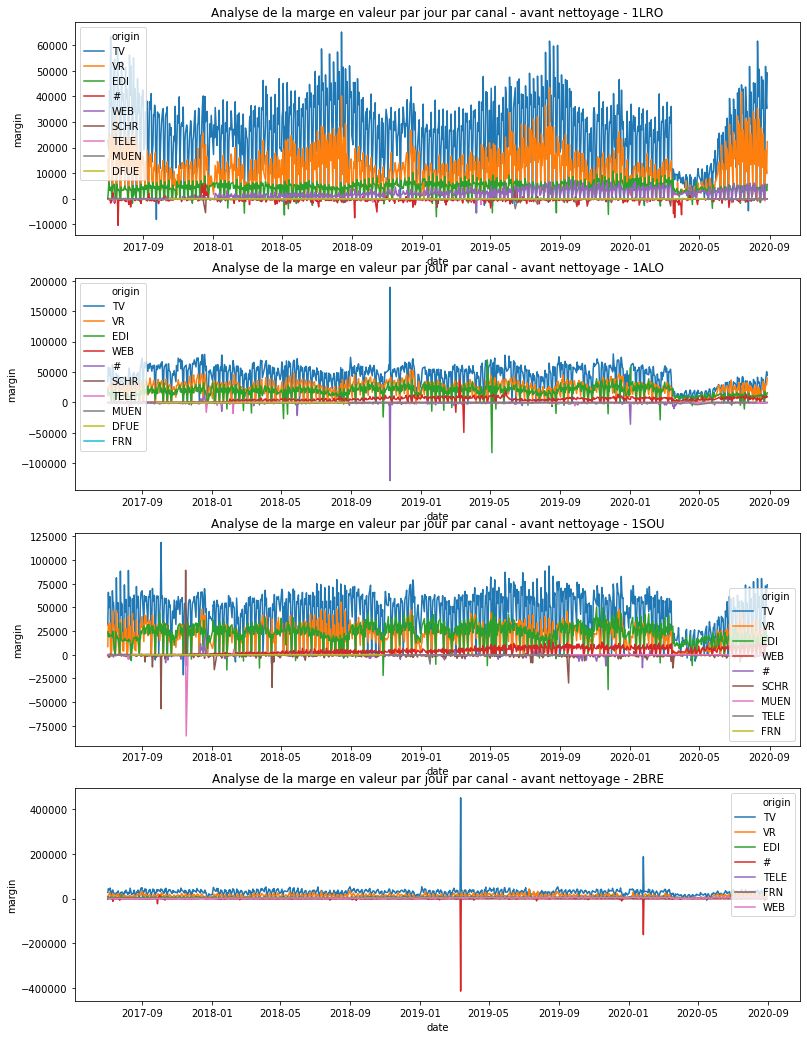

In [21]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1)
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')


# fig, ax = plt.subplots(figsize=(15, 12))
# data_to_plot = (
# data.loc[data.orgacom == '1ALO']
#     .groupby(['date', 'origin'])['margin']
#     .sum()
#     .unstack('origin')
#     .rolling(1)
#     .mean()
#     .stack('origin')
#     .rename('margin')
#     .reset_index()
# )
# sns.lineplot(data=data_to_plot, x='date', y='margin', hue='origin', ax=ax)
# ax.set_title('Analyse de la marge en valeur par jour par canal - avant nettoyage')
# ax.set_xticklabels([])

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [22]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [23]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin        -9.685755e-08
brutrevenue   -2.384186e-07
weight        -1.490116e-08
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -7.450581e-07
brutrevenue    5.960464e-08
weight         7.450581e-08
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -2.980232e-08
brutrevenue   -1.549721e-06
weight         1.341105e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin         2.086163e-07
brutrevenue   -1.490116e-07
weight         2.980232e-08
dtype: float64
CPU times: user 5min 5s, sys: 1min 28s, total: 6min 34s
Wall time: 6min 33s


In [24]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.sample(10)

order_num orgacom   month    week       date pricetype      client  \
5426216     912816    1SOU  201809  201838 2018-09-18      ZTCR  0000218673   
418350     2255375    2BRE  201709  201736 2017-09-07      ZTCE  0000140706   
2454786     431507    1ALO  201802  201805 2018-02-02      ZTCE  0000211919   
8684400    1479894    1SOU  201906  201925 2019-06-21      ZTCE  0000222434   
5676504    2559491    2BRE  201911  201945 2019-11-05      ZTCE  0000262492   
5967454    2576219    2BRE  201912  201951 2019-12-17      ZTCE  0000072642   
238469       35563    1ALO  201707  201730 2017-07-25      ZTCE  0000027219   
3638367    1295819    1LRO  201904  201914 2019-04-05      ZTCE  0000126480   
4311989     776307    1ALO  201807  201829 2018-07-17      ZTCR  0000064935   
9487837    1596245    1SOU  201908  201934 2019-08-25      ZTCE  0000244956   

        doctype origin salesgroup  ... margincur marginperkg  purchcost  \
5426216    ZC10     VR        963  ...       EUR        0.44       3.22   
418350     ZC10     TV        A24  ...       EUR        0.03       2.38   
2454786    ZC10    EDI        595  ...       EUR       -0.48      49.13   
8684400    ZC10    EDI        782  ...       EUR        0.33      16.28   
5676504    ZC10     TV        A28  ...       EUR        0.49       8.64   
5967454    ZC10     TV        N04  ...       EUR        2.21      16.46   
238469     ZC10    EDI        589  ...       EUR        0.18       8.97   
3638367    ZC10     TV        746  ...       EUR        0.28      20.80   
4311989    ZC10     TV        F54  ...       EUR        0.36      29.94   
9487837    ZC10    EDI        801  ...       EUR        0.00       0.77   

        purchcostperkg       PMVK marginpercent  _duplicated  margin  \
5426216       0.644000   1.080000      0.403704        False    2.18   
418350        0.238000   0.265000      0.101887        False    0.27   
2454786       6.823611   6.338889     -0.076468        False   -3.49   
8684400       3.256000   3.588000      0.092531        False    1.66   
5676504       2.133333   2.627160      0.187970        False    2.00   
5967454      16.460000  18.670000      0.118372        False    2.21   
238469        0.897000   1.078000      0.167904        False    1.81   
3638367       4.333333   4.608333      0.059675        False    1.32   
4311989       6.969274   7.332402      0.049524        False    1.56   
9487837            inf        NaN           NaN        False   -0.77   

         brutrevenue  weight  
5426216         5.40   5.000  
418350          2.65  10.000  
2454786        45.64   7.200  
8684400        17.94   5.000  
5676504        10.64   4.050  
5967454        18.67   1.000  
238469         10.78  10.000  
3638367        22.12   4.800  
4311989        31.50   4.296  
9487837         0.00   0.000  

[10 rows x 25 columns]

In [25]:
# mask_ZC = data.doctype.isin(['ZC10'])
# mask_ZA = data.doctype.isin(['ZA01', 'ZA02'])
# myfields = ['orgacom',
#             'doctype',
#             'date',
#             'origin',
#             'material',
#             'client',
#             'brutrevenue',
#             'weight',
#             'PMVK',
#             'marginperkg',
#             'margin',
#             'purchcost',
#             'purchcostperkg']

In [26]:
# grouper_fields = ['orgacom', 'date', 'client', 'material']
# raw_avoirs = data.loc[mask_ZA, grouper_fields + ['margin', 'brutrevenue', 'weight']].copy()
# avoirs = raw_avoirs.groupby(grouper_fields, observed=True).sum()
# avoirs

On identifie ensuite les lignes de commandes qui ne sont pas dupliquées dans le dataset initial.

In [27]:
# mask_dup_ZC = data.loc[mask_ZC].duplicated(grouper_fields, keep=False).rename('_duplicated')
# print(f'Number of duplicated lines in orders: {sum(mask_dup_ZC)}')
# mask_dup_ZC = mask_dup_ZC.reindex(data.index, fill_value=False)
# data = (data.merge(mask_dup_ZC, how='left', left_index=True, right_index=True))

On calcule les indicateurs à remplacer : 
  - correspondent à des commandes, dont les lignes ne sont pas dupliquées
  - ne font pas passer les poids ou les CA bruts négatifs

In [28]:
# indicators = ['margin', 'weight', 'brutrevenue']
# to_update = (
# data.loc[~data._duplicated & mask_ZC, grouper_fields + indicators]
#     .merge(avoirs, left_on=grouper_fields, right_index=True, validate='1:1')
# )
# for indicator in indicators:
#     to_update[indicator] = to_update[indicator + '_x'] + to_update[indicator + '_y']
# to_update = to_update.loc[(to_update.weight >= 0) & (to_update.brutrevenue >= 0)]
# to_update.sample(5)

On contrôle que les quelques grosses lignes en erreur sont bien corrigées.

In [29]:
# to_update.sort_values('margin_x', ascending=False).head(5)

In [30]:
# to_update.margin_y.sum()

On retire les indicateurs temporaires : 

In [31]:
# to_update.drop(columns=['margin_x', 'margin_y', 'weight_x', 'weight_y', 'brutrevenue_x', 'brutrevenue_y'], inplace=True)

Suppression des avoirs :

In [32]:
# data.set_index(grouper_fields)

In [33]:
# mask_to_del = data.set_index(grouper_fields).index.isin(to_update.set_index(grouper_fields).index)

In [34]:
# data = data.loc[mask_to_del
#                 | ~data.doctype.isin(['ZA01', 'ZA02'])]

Mise à jour des lignes de commande : 

In [35]:
# merged = data.merge(to_update, on=grouper_fields, how='left', indicator=True)
# del(to_update)

In [36]:
# merged_mask_ZC = merged.doctype.isin(['ZC10',])
# for indicator in indicators:
#     merged.loc[:, indicator + '_z'] = merged[indicator + '_x'].where(merged[indicator + '_y'].isna() | ~merged_mask_ZC,
#                                                                     merged[indicator + '_y'])
    
# merged['margin_z'].sum()

In [37]:
# for indicator in indicators:
#     merged[indicator] = merged[indicator + '_z']
#     merged = merged.drop(columns=[indicator + '_x', indicator + '_y', indicator + '_z'])
# merged = merged.drop(columns='_merge')
# data = merged
# del(merged)

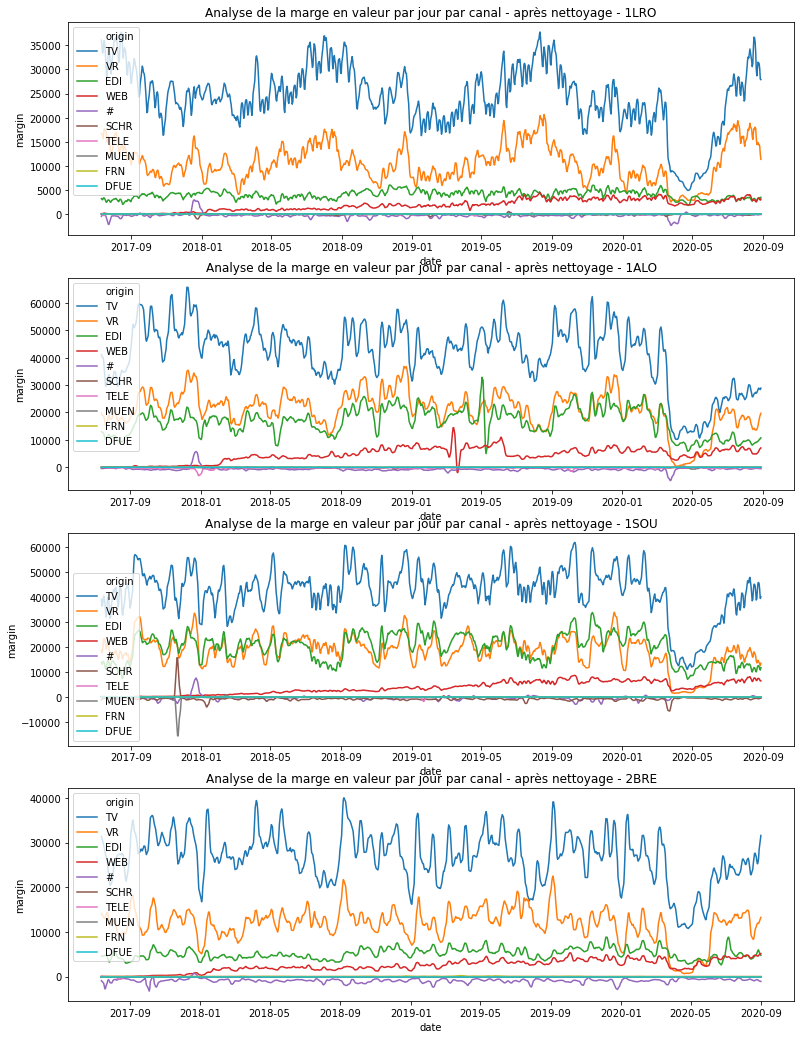

In [38]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(10, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')


## Affichage des indicateurs par succursale et canal

In [39]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

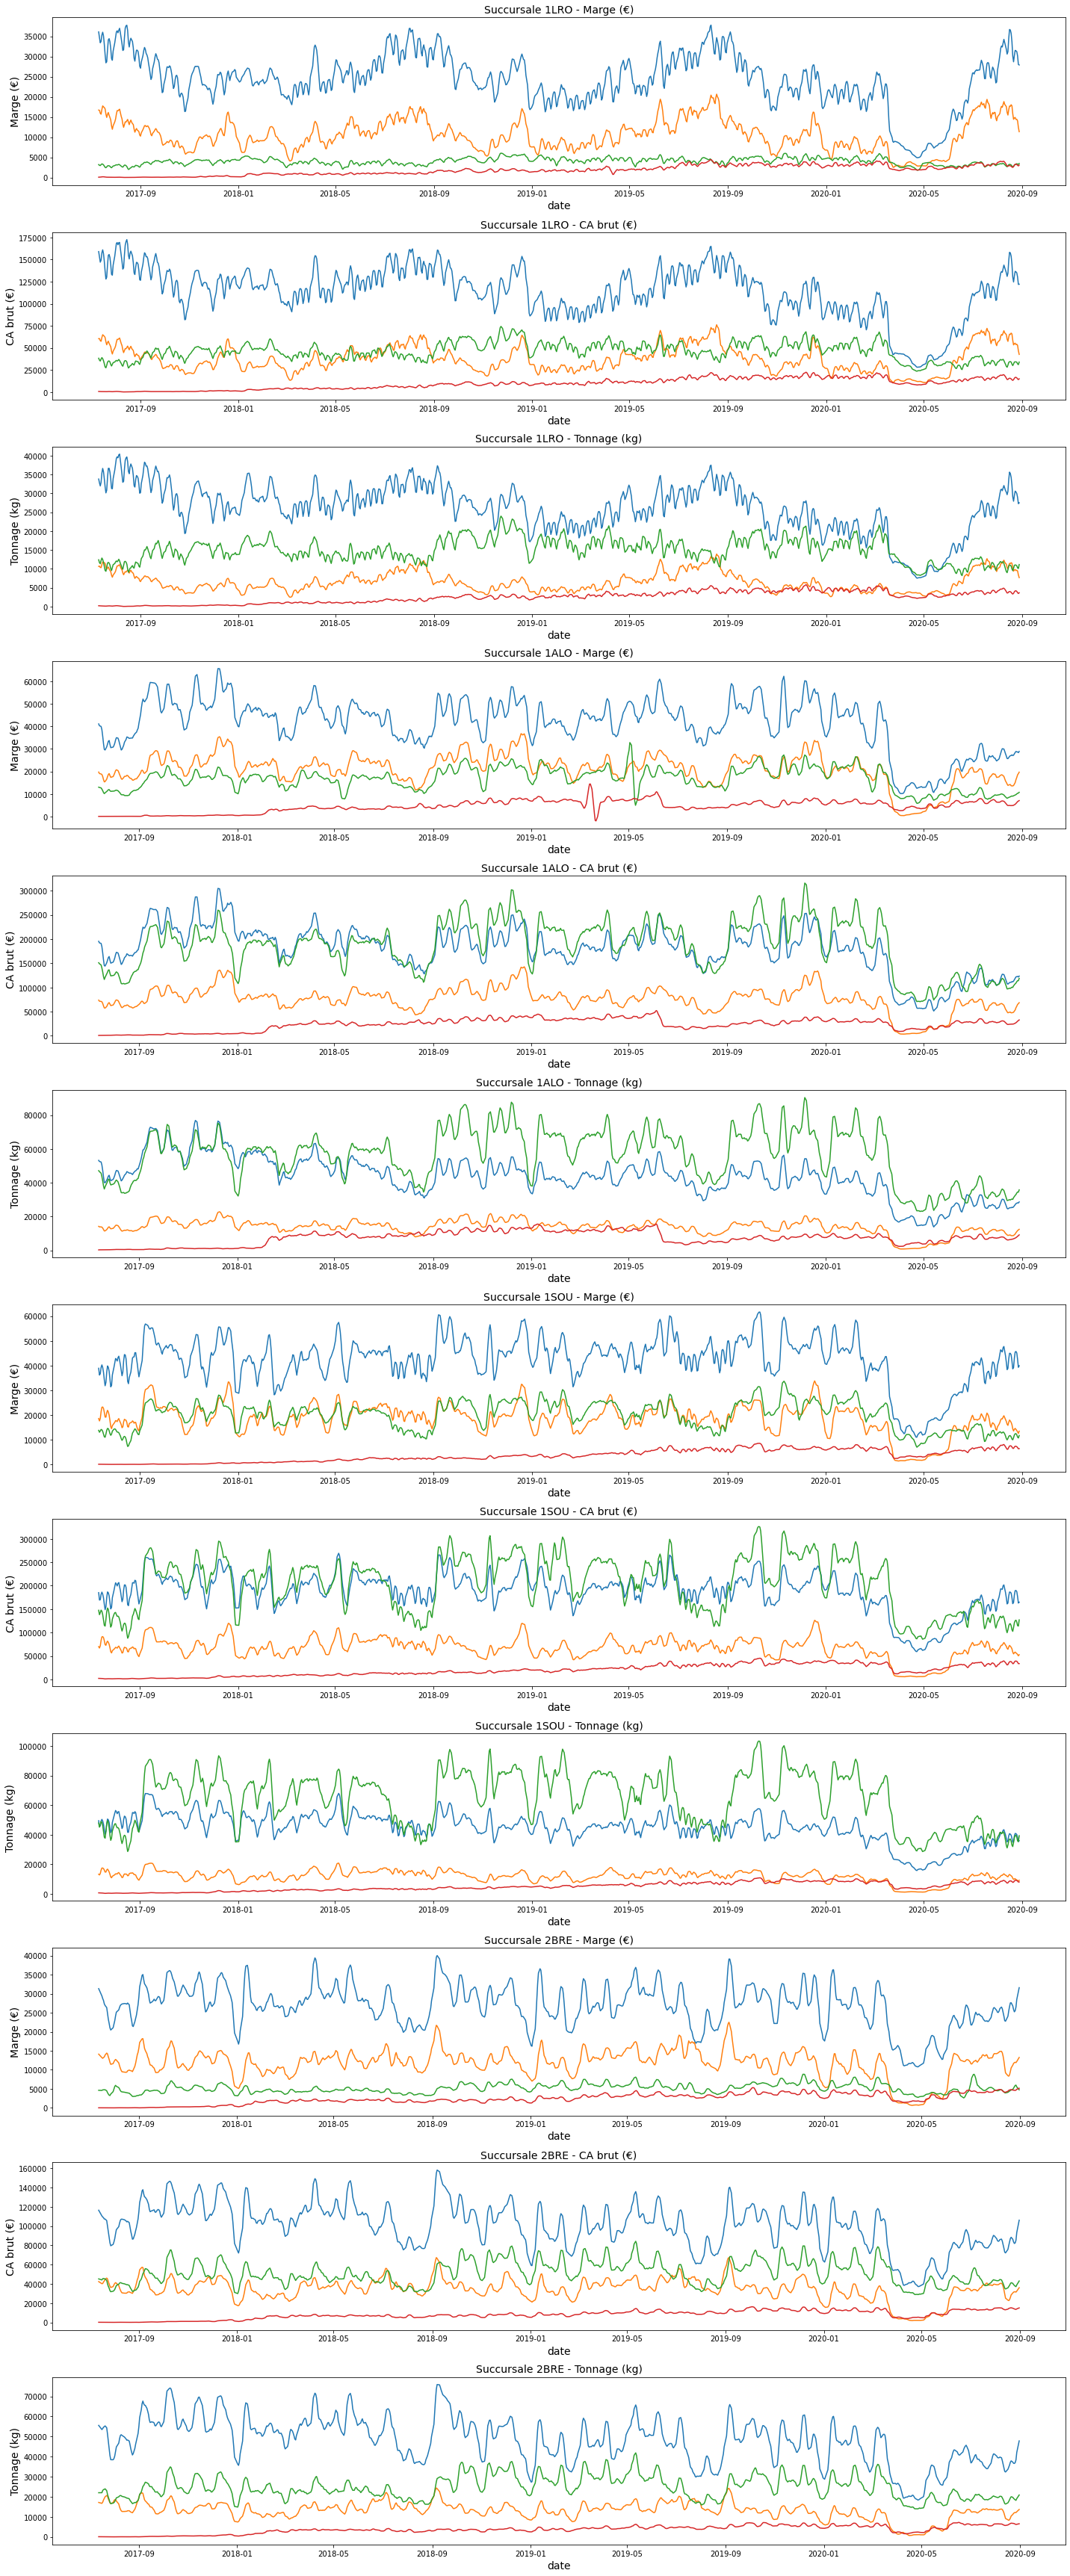

In [40]:
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )
for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot, x='date', y=indicator, hue='origin', ax=axs[i * len(indicator_map) + j])
        axs[i * len(indicator_map) + j].get_legend().remove()
        axs[i * len(indicator_map) + j].set_title(f'Succursale {suc} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncols=4)
fig.tight_layout()

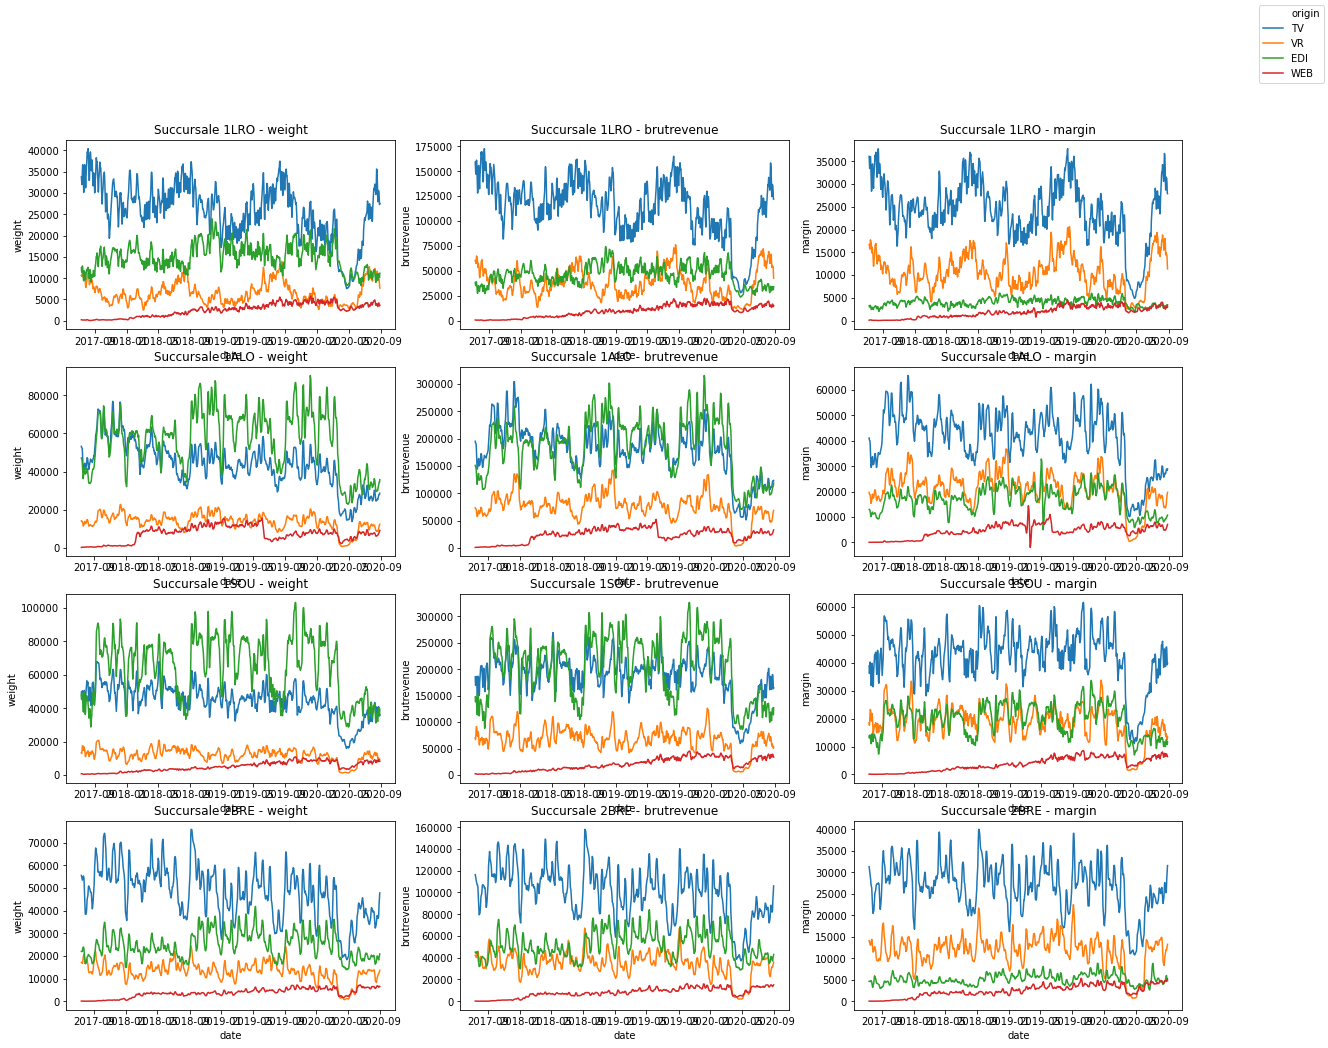

In [41]:
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)), nrows=len(SV), ncols=len(indicators), squeeze=False)
for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicators):
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot, x='date', y=indicator, hue='origin', ax=axs[i, j])
        axs[i, j].get_legend().remove()
        axs[i, j].set_title(f'Succursale {suc} - {indicator}')
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)


## Filtration des canaux "exotiques"

In [42]:
boxplot_args = {'showmeans': True, 
                'meanprops': {'markerfacecolor': 'black',
                              'markeredgecolor': 'black',
                              'marker': 's',
                             }
               }

In [43]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
# origins = ['TV', 'VR', 'WEB', 'EDI']
data['origin2'] = data.origin.astype(origin2_cat)

In [44]:
# fig, axs = plt.subplots(figsize=(5, 15), nrows=len(indicators), squeeze=False)
# data_to_plot = data.loc[data.origin.isin(['WEB', 'TV', 'VR', 'EDI']) &
#                         data.doctype.isin(['ZC10'])]
# for j, indicator in enumerate(indicators):
#     sns.boxplot(data=data_to_plot, y=indicator, x='orgacom', hue='origin2', ax=axs[j, 0], showfliers=False, **boxplot_args)
#     axs[j, 0].get_legend().remove()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# fig.suptitle('Analyse des postes de commandes par canal', fontsize=16, y=.925)

## Affichage des indicateurs par commande

In [45]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

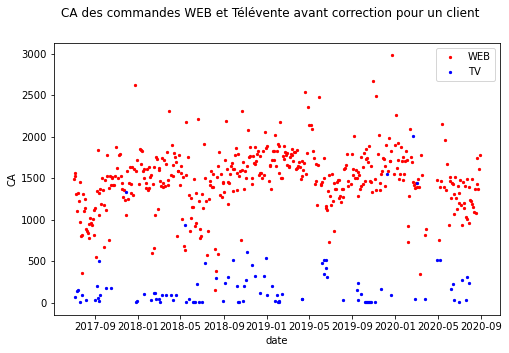

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color='red',
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color='blue',
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('date')
ax.set_ylabel('CA')
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client')
ax.legend()


### Calcul du canal majoritaire par OC, client, jour

On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [47]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [48]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

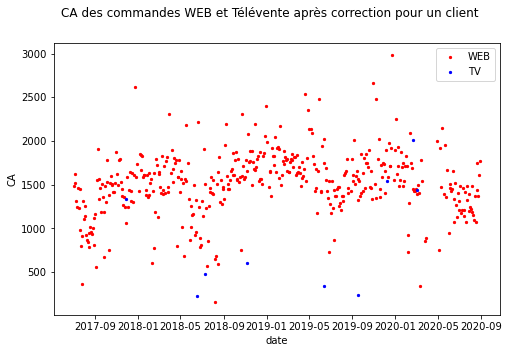

In [49]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color='red',
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color='blue',
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('date')
ax.set_ylabel('CA')
fig.suptitle('CA des commandes WEB et Télévente après correction pour un client')
ax.legend()


On ajoute quelques données du dataset client.

In [50]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')

In [51]:
orders

margin  brutrevenue   weight  linecount  \
orgacom date       client                                                
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9   
        2017-08-28 0000065940   44.36       105.93    8.048         10   
        2017-09-08 0000065940   17.60        40.35    3.000          2   
        2017-09-15 0000065940  100.12       236.77   20.312          3   
        2017-09-25 0000065940   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    2020-08-31 0000282373  177.42      1401.58  488.036         88   
                   0000283953   43.79       421.67  564.980         28   
                   0000284089   89.39       186.75   90.200         12   
                   0000284540  262.04      1252.07  639.326         97   
                   0000284735  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  
orgacom date       client                                                   
1SOU    2017-07-03 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-08-28 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-08 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-15 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-25 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
...                               ...  ...  ...  ...  ...  ..   ...    ...  
2BRE    2020-08-31 0000282373     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705  
                   0000283953     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506  
                   0000284089      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN  
                   0000284540      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432  
                   0000284735      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN  

[2444326 rows x 12 columns]

In [52]:
orders.merge(df_clt.loc[:, clt_fields],
                      left_on=['orgacom', 'client'],
                      right_index=True,
                      validate='m:1',
                      how='left',
                      indicator=True).loc[lambda x: x._merge != 'both']

Empty DataFrame
Columns: [margin, brutrevenue, weight, linecount, origin2, seg1_x, seg2_x, seg3_x, seg4_x, cat_x, sscat_x, hier4_x, seg1_y, seg2_y, seg3_y, seg4_y, cat_y, sscat_y, hier4_y, _merge]
Index: []

In [53]:
order_count

2444326

In [54]:
len(orders)

2444326

In [55]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()

Text(0.5, 0.91, 'Analyse des commandes par canal')

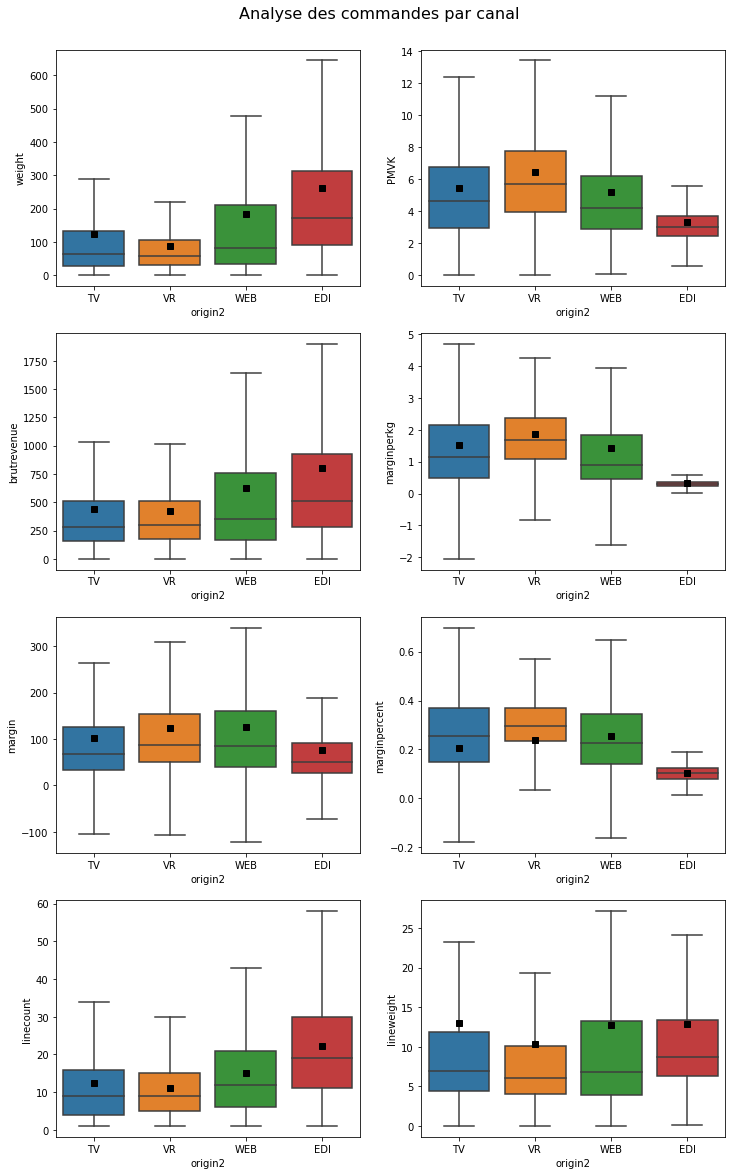

In [56]:
indicators2 = ['weight', 'brutrevenue', 'margin', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='origin2', hue=None, ax=axs[x, y], showfliers=False, **boxplot_args)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

In [57]:
orders.groupby('origin2').margin.describe()

count        mean         std      min    25%    50%     75%  \
origin2                                                                     
EDI       596597.0   75.469443   98.341545 -5430.55  26.29  50.26   91.52   
TV       1263539.0  103.214684  143.144416 -6435.52  33.53  66.94  125.94   
VR        485707.0  124.219015  141.749354 -2102.62  49.58  87.40  153.39   
WEB        98483.0  125.314285  143.406539  -378.54  39.98  85.30  160.02   

              max  
origin2            
EDI       9880.62  
TV       26866.17  
VR       25151.97  
WEB       6681.78

In [58]:
orders.groupby(['origin2']).mean().loc[:, indicators2].style.format(formats)

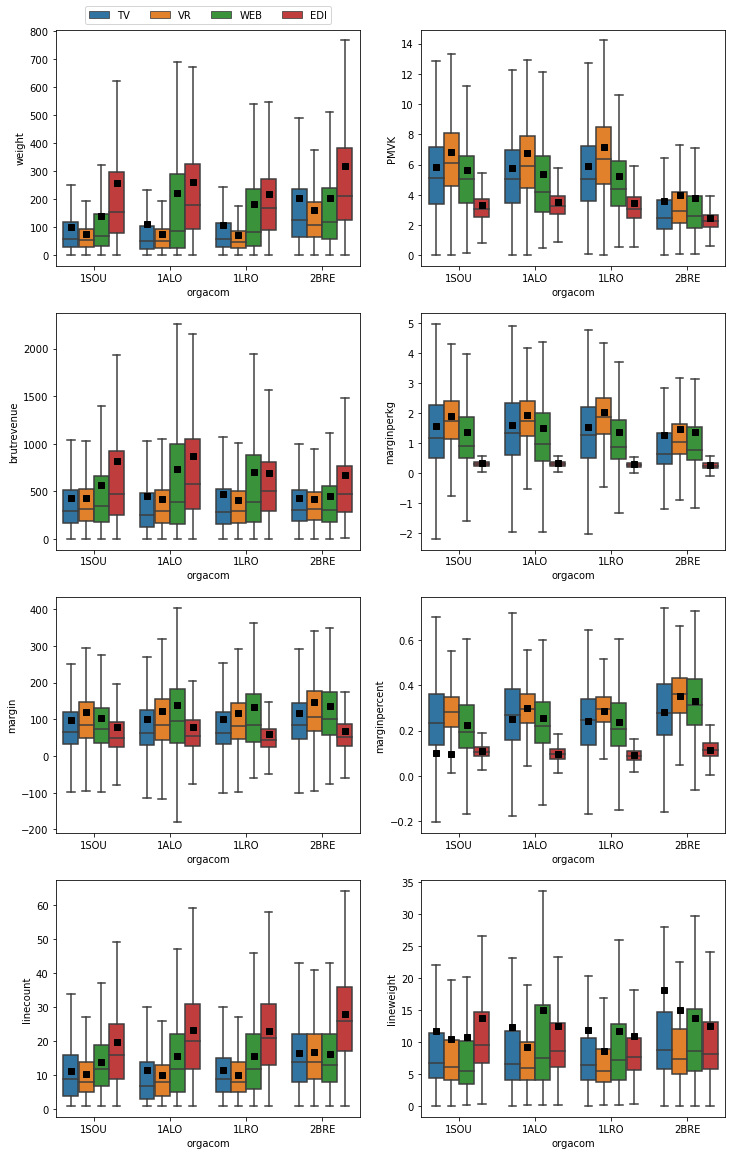

In [59]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='orgacom', hue='origin2', ax=axs[x, y], showfliers=False, **boxplot_args)
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [60]:
orders.groupby(['orgacom', 'origin2']).mean().loc[:, indicators2].style.format(formats)

In [61]:
vr_1SOU = orders.loc[(orders.orgacom == '1SOU') & (orders.origin2 == 'VR')]
print(f'{vr_1SOU.loc[(vr_1SOU.marginpercent == vr_1SOU.marginpercent.min())].marginpercent.iloc[0]:.2%}')
vr_1SOU.loc[(vr_1SOU.marginpercent == vr_1SOU.marginpercent.min()), :]

-210400.00%


orgacom       date      client  margin  brutrevenue  weight  linecount  \
3768    1SOU 2019-12-10  0000066228  -42.08         0.02     2.0          1   

     origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  PMVK  marginperkg  \
3768      VR   Z3   Z4   ZI   ZB  ZM   Z16  10838  0.01       -21.04   

      marginpercent  lineweight  
3768        -2104.0         2.0

In [62]:
data.loc[(data.orgacom == '1SOU') &
         (data.client == '0000140169') &
         (data.date == '2019-04-02') &
         (data.origin == 'VR')]

order_num orgacom   month    week       date pricetype      client  \
7685403    1304465    1SOU  201904  201914 2019-04-02       ZTG  0000140169   

        doctype origin salesgroup  ... marginperkg purchcost  purchcostperkg  \
7685403    ZC10     VR        791  ...       -8.56     21.42           8.568   

          PMVK marginpercent _duplicated  margin  brutrevenue  weight  origin2  
7685403  0.004       -2141.0       False  -21.41         0.01     2.5       VR  

[1 rows x 26 columns]

In [63]:
dicted_clt_fields = {key: 'object' for key in clt_fields}

[Text(0, 0, 'ZI - Restau Coll. Autogérée'),
 Text(1, 0, 'ZL - Restau Com. Structurée'),
 Text(2, 0, 'ZK - Restau Com. Indépendante'),
 Text(3, 0, 'ZJ - Restau Coll. Concédée')]

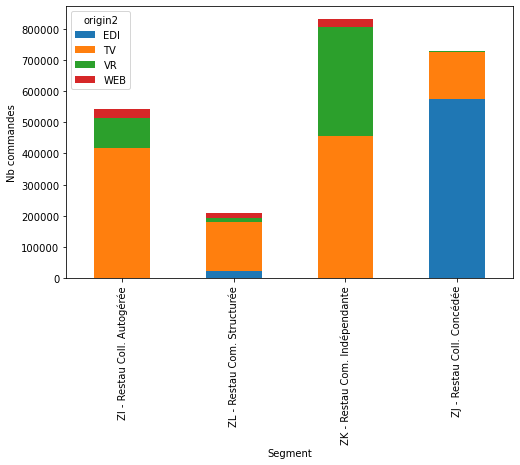

In [64]:
mask_filter = (orders.seg1.isin(['Z3']) & (orders.hier4 != '198863'))

fig, ax = plt.subplots(figsize=(8, 5))
(
orders.loc[mask_filter]
      .pivot_table(index='seg3',
                   columns='origin2',
                   aggfunc='size',
                   observed=True)
      .plot(kind='bar', stacked=True, ax=ax)
)
ax.set_ylabel('Nb commandes')
ax.set_xlabel('Segment')
ax.set_xticklabels(['ZI - Restau Coll. Autogérée',
                    'ZL - Restau Com. Structurée',
                    'ZK - Restau Com. Indépendante', 
                    'ZJ - Restau Coll. Concédée'])
    

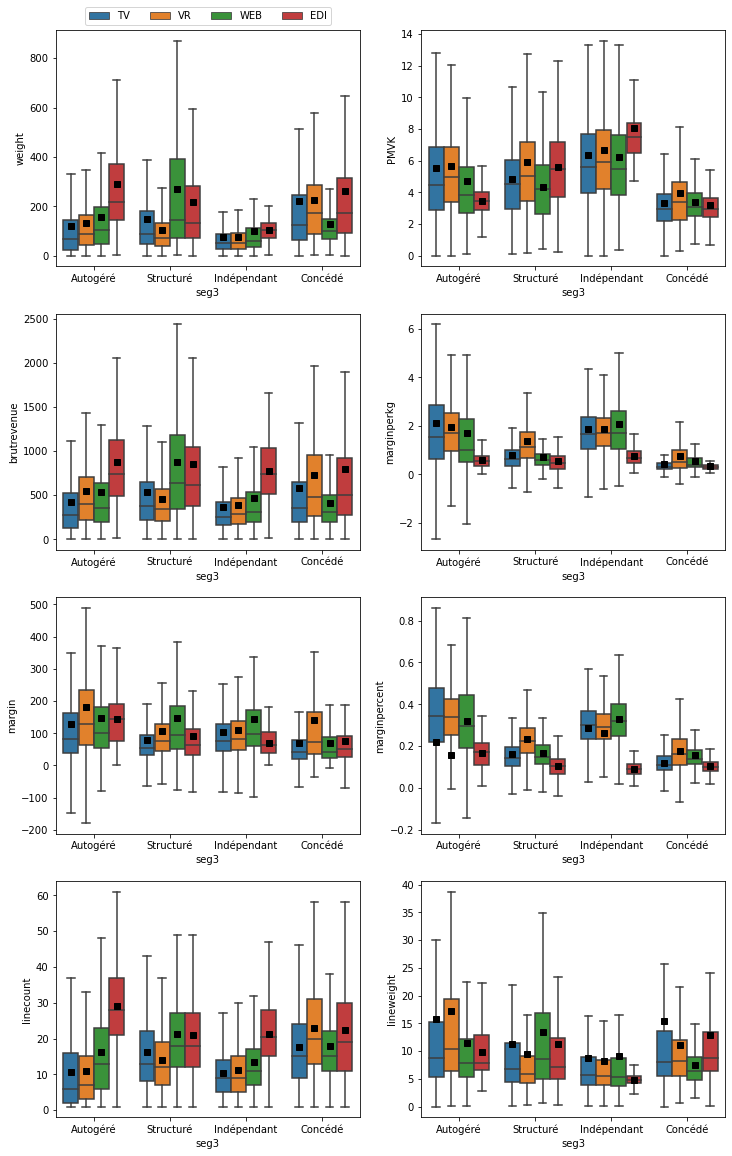

In [65]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.astype(dicted_clt_fields).loc[mask_filter],
                y=indicator,
                x='seg3',
                hue='origin2',
                ax=axs[x, y],
                showfliers=False, 
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    texts = [lib_seg.loc[(3, text.get_text())].iloc[0] for text in axs[x, y].get_xticklabels()]
    axs[x, y].set_xticklabels(texts)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [66]:
(
orders.loc[orders.seg1.isin(['Z3']), indicators2 + ['orgacom', 'seg3']]
      .groupby(['orgacom', 'seg3'], observed=True)
      .mean()
      .style.format(formats)
)

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [67]:
orders = compute_zscores(orders,
                         grouper_fields=['orgacom', 'client'],
                         indicators=indicators2)

weight done!
brutrevenue done!
margin done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


In [68]:
# def compute_zscores(df, grouper_fields, indicators, suffix='_clt_zscore'):
#     grouped = df.groupby(grouper_fields, observed=True)
#     for indicator in indicators:
#         mean_ds = grouped[indicator].transform('mean')
#         std_ds = grouped[indicator].transform('std')
#         df[indicator + suffix] = ((df[indicator] - mean_ds) / std_ds).replace([np.inf, -np.inf], np.nan).fillna(0.)
#         del(mean_ds)
#         del(std_ds)
#         print(f'{indicator} done!')
#     print('ALL DONE!')

In [69]:
# for indicator in indicators2:
#     grouped = orders.groupby(['orgacom', 'client'], observed=True)
#     orders[indicator + '_clt_mean'] = grouped[indicator].transform('mean')
#     orders[indicator + '_clt_std'] = grouped[indicator].transform('std')
#     orders[indicator + '_clt_zscore'] = ((orders[indicator] - orders[indicator + '_clt_mean']) /
#                                          orders[indicator + '_clt_std']).replace([np.inf, -np.inf], np.nan).fillna(0.)
#     del(orders[indicator + '_clt_mean'])
#     del(orders[indicator + '_clt_std'])
#     print(f'{indicator} done!')
# print('ALL DONE!')

In [70]:
orders.describe().style.format('{:.5f}')

Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

0000027987 - CAFET CORA VILLERS SEMEUSE - VSM


<AxesSubplot:xlabel='date'>

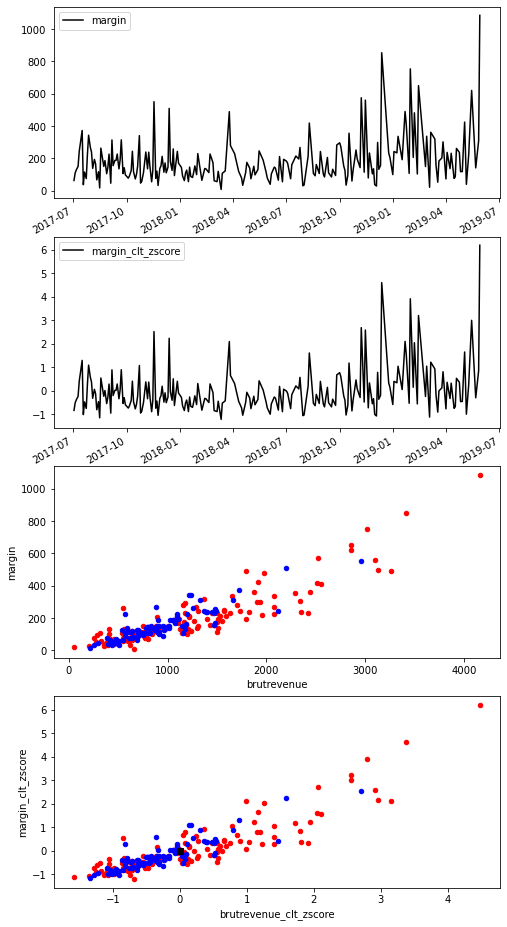

In [71]:
sample = orders.loc[orders.origin2 == 'WEB'].sample(1).iloc[0]
oc, client = sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.client == client)
mask_web = mask_clt & (orders.origin2 == 'WEB')
mask_other = mask_clt & (orders.origin2 != 'WEB')
orders.loc[mask_web].plot(kind='scatter', y='margin', x='brutrevenue', color='red', ax=axs[2])
orders.loc[mask_other].plot(kind='scatter', y='margin', x='brutrevenue', color='blue', ax=axs[2])
orders.loc[mask_web].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='red', ax=axs[3])
orders.loc[mask_other].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='blue', ax=axs[3])
axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])

### Un exemple issu d'O'Tacos

0000245517 - O TACOS REIMS  D ERLON


<AxesSubplot:xlabel='date'>

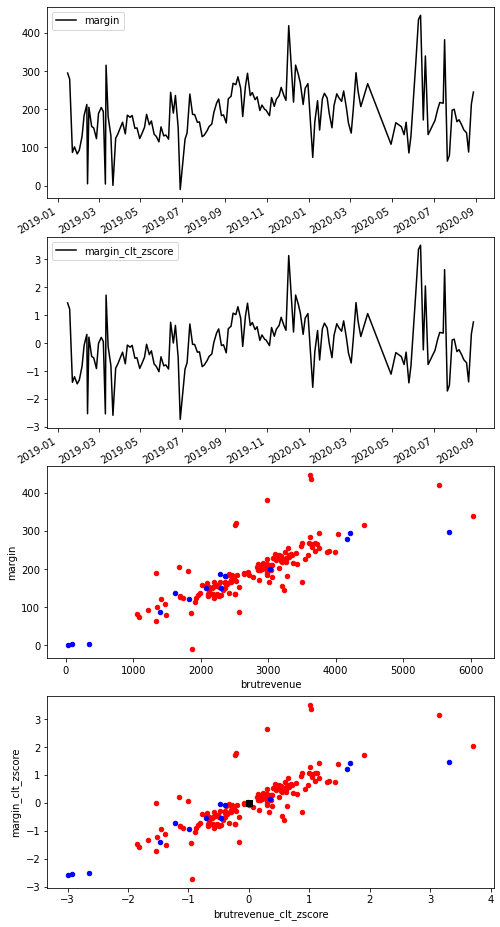

In [72]:
sample = orders.loc[(orders.origin2 == 'WEB') & (orders.hier4 == '198863')].sample(1).iloc[0]
oc, client = sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.client == client)
mask_web = mask_clt & (orders.origin2 == 'WEB')
mask_other = mask_clt & (orders.origin2 != 'WEB')
orders.loc[mask_web].plot(kind='scatter', y='margin', x='brutrevenue', color='red', ax=axs[2])
orders.loc[mask_other].plot(kind='scatter', y='margin', x='brutrevenue', color='blue', ax=axs[2])
orders.loc[mask_web].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='red', ax=axs[3])
orders.loc[mask_other].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='blue', ax=axs[3])
axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])

Par contre, cela change les indicateurs si 

<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

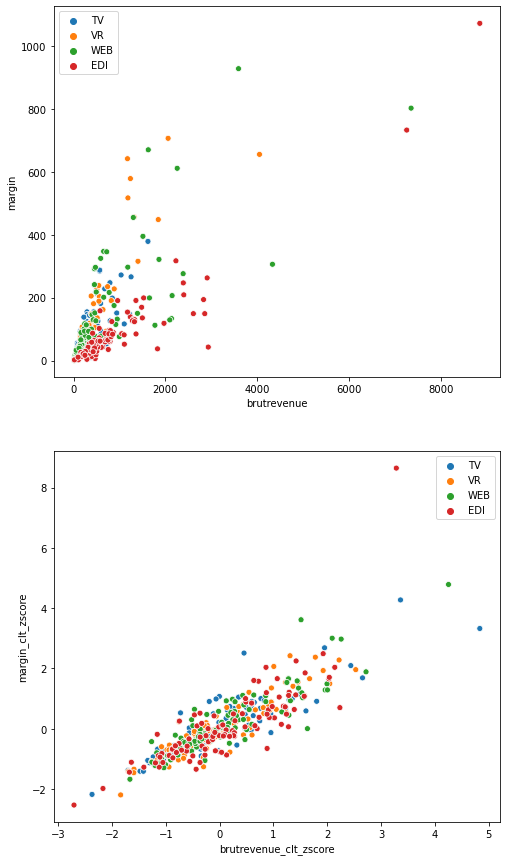

In [73]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

Text(0.5, 0.91, 'Analyse des commandes par canal')

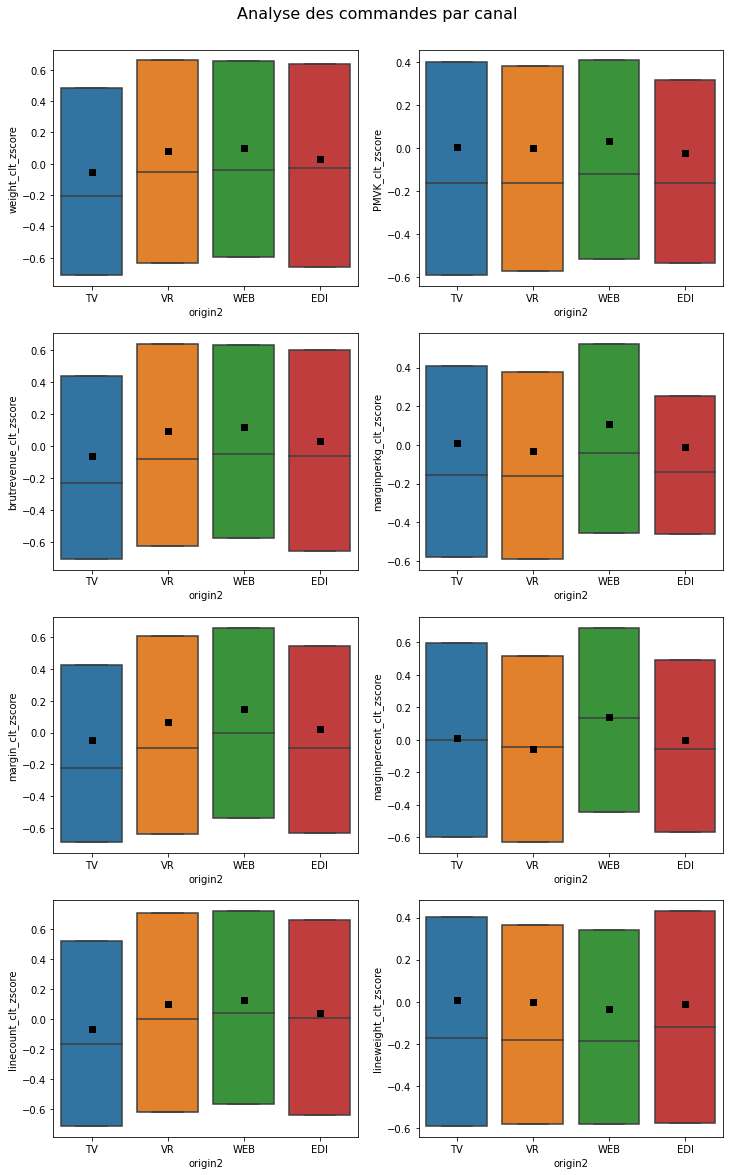

In [74]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator + '_clt_zscore', x='origin2', hue=None, ax=axs[x, y], showfliers=False, whis=0., **boxplot_args)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

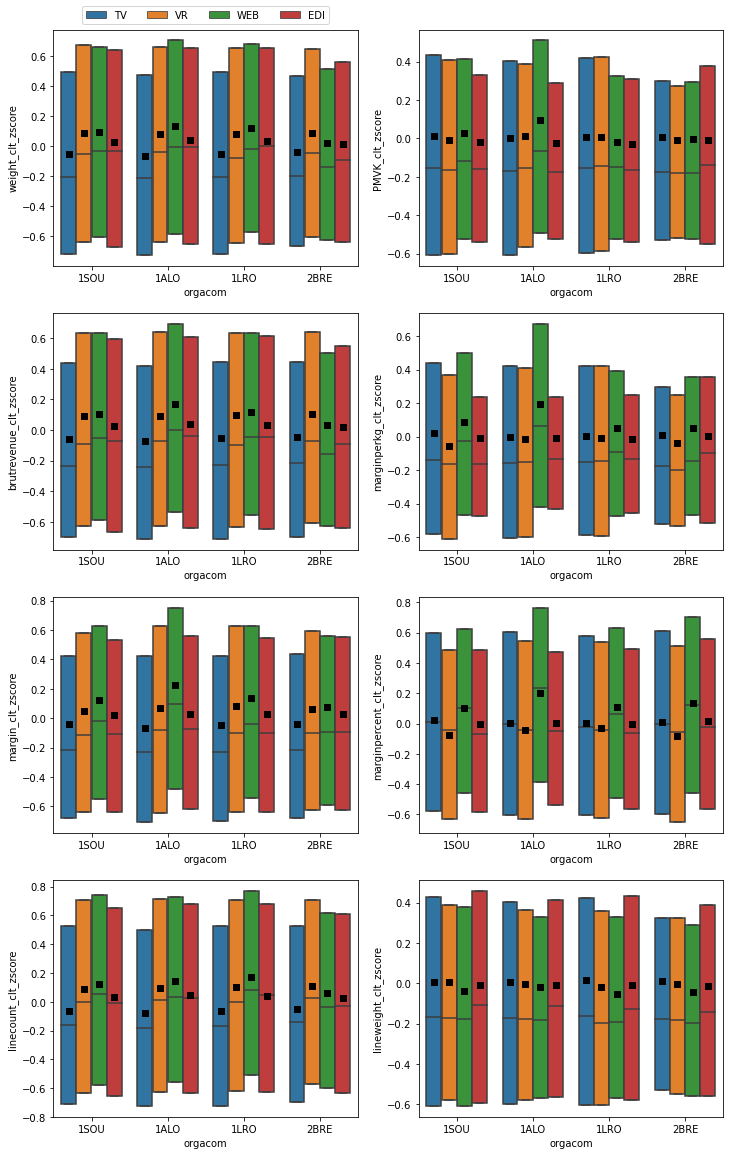

In [75]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders,
                y=indicator + '_clt_zscore',
                x='orgacom',
                hue='origin2',
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

Text(0.5, 1.025, 'Analyse vs. moyenne des commandes par canal et segment de restauration')

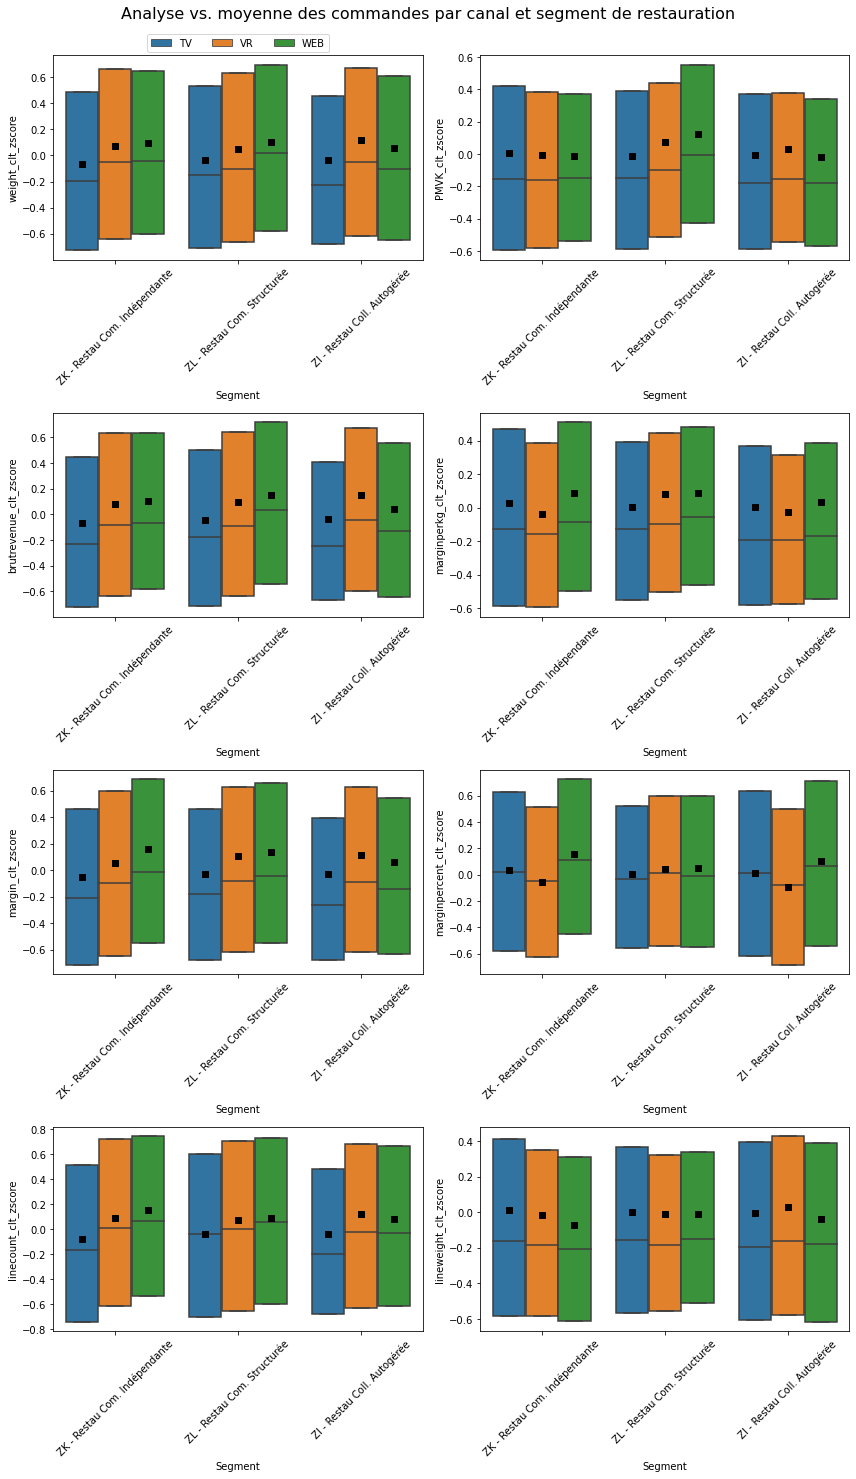

In [76]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.loc[mask_filter & #.astype(dicted_clt_fields)
                                ~orders.seg3.isin(['ZJ']) &
                                ~orders.origin2.isin(['EDI'])],
                y=indicator + '_clt_zscore',
                x='seg3',
                order=['ZK', 'ZL', 'ZI'],
                hue='origin2',
                hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Segment')
    axs[x, y].set_xticklabels([
                               'ZK - Restau Com. Indépendante', 
                               'ZL - Restau Com. Structurée',
                               'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
                              ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Analyse vs. moyenne des commandes par canal et segment de restauration', fontsize=16, y=1.025)

## Première modélisation : bascule à la première commande Web

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [77]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [78]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [79]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [80]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
2BRE    SL008B     2017-12-01       TV
        SL008C     2017-07-11       TV
        SL008R     2017-07-28       TV
        SL009N     2017-07-04       TV
        SLD008B    2018-09-14       TV

[37000 rows x 1 columns]

Ajout de 2 lignes de test dans la table des mises à jour de statut.

In [81]:
# status_updates.loc[('1LRO', '0000096476', pd.to_datetime('2018-01-01'))] = 'TEST1'
# status_updates.loc[('1LRO', '0000096476', pd.to_datetime('2019-04-27'))] = 'TEST2'
# status_updates.loc[idx[:, '0000096476', :]]

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [82]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [83]:
orders.sample(5)

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000086677 2019-10-25   38.72       387.81  126.655         21   
1ALO    0000163954 2019-06-26  165.72       424.54   71.073         21   
1SOU    0000070369 2018-07-30   44.88       159.29   34.720          8   
2BRE    0000074687 2019-08-12  118.10       352.89  123.805         18   
1SOU    0000069193 2019-01-10  108.30       614.94  303.355         20   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000086677 2019-10-25      TV   Z3   Z4   ZJ   ZF  ZN  ...   6.031190   
1ALO    0000163954 2019-06-26      VR   Z3   Z5   ZK   ZG  ZW  ...   3.384429   
1SOU    0000070369 2018-07-30      TV   Z3   Z4   ZI   ZB  ZL  ...   4.340000   
2BRE    0000074687 2019-08-12      VR   Z3   Z4   ZI   ZD  ZN  ...   6.878056   
1SOU    0000069193 2019-01-10     EDI   Z3   Z4   ZJ   ZF  ZP  ...  15.167750   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000086677 2019-10-25         -0.237634               -0.393757   
1ALO    0000163954 2019-06-26         -0.180432                0.308641   
1SOU    0000070369 2018-07-30         -0.176450               -0.359654   
2BRE    0000074687 2019-08-12         -0.996295               -1.002326   
1SOU    0000069193 2019-01-10          0.902931                0.091283   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000086677 2019-10-25          -0.544542              0.054530   
1ALO    0000163954 2019-06-26           0.641666              0.133463   
1SOU    0000070369 2018-07-30          -0.555747              1.725055   
2BRE    0000074687 2019-08-12          -0.779529             -1.850698   
1SOU    0000069193 2019-01-10           1.343808              0.856421   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
orgacom client     date                                                  
1SOU    0000086677 2019-10-25        -0.381971               -0.394306   
1ALO    0000163954 2019-06-26         0.711581                1.224118   
1SOU    0000070369 2018-07-30        -0.488091               -0.636801   
2BRE    0000074687 2019-08-12        -0.263110                0.001940   
1SOU    0000069193 2019-01-10        -0.974755                0.625441   

                               marginpercent_clt_zscore  \
orgacom client     date                                   
1SOU    0000086677 2019-10-25                 -0.332909   
1ALO    0000163954 2019-06-26                  1.448389   
1SOU    0000070369 2018-07-30                 -0.623837   
2BRE    0000074687 2019-08-12                  0.416975   
1SOU    0000069193 2019-01-10                  2.222302   

                               lineweight_clt_zscore  clt_stat  
orgacom client     date                                         
1SOU    0000086677 2019-10-25              -0.443346        TV  
1ALO    0000163954 2019-06-26              -0.477230        VR  
1SOU    0000070369 2018-07-30              -1.061207        VR  
2BRE    0000074687 2019-08-12               1.130178       WEB  
1SOU    0000069193 2019-01-10               0.128053       EDI  

[5 rows x 25 columns]

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [84]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

margin  brutrevenue      weight  linecount  \
orgacom client     clt_stat                                                 
1SOU    0000010078 TV           11.01        20.82       2.350          2   
                   WEB         221.62       452.95      25.460         18   
        0000019613 TV        47824.80    470059.03  129763.078       5624   
        0000043428 TV        20550.61    107904.93   24274.185       3153   
        0000043827 VR          922.65      4220.09     862.249        116   
...                               ...          ...         ...        ...   
2BRE    SL008B     TV          190.97      4398.58    3303.984          2   
        SL008C     TV         7578.42     71848.30   21946.816        367   
        SL008R     TV          263.63      6992.88    2009.948         43   
        SL009N     TV         5107.84     14556.72    4057.578        172   
        SLD008B    TV            3.82        70.05       4.400          1   

                             ordercount  
orgacom client     clt_stat              
1SOU    0000010078 TV                 1  
                   WEB                6  
        0000019613 TV               485  
        0000043428 TV               163  
        0000043827 VR                 9  
...                                 ...  
2BRE    SL008B     TV                 2  
        SL008C     TV                95  
        SL008R     TV                25  
        SL009N     TV                48  
        SLD008B    TV                 1  

[37000 rows x 5 columns]

In [85]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

date    margin  brutrevenue      weight  \
orgacom client     new_stat                                                 
1SOU    0000010078 TV       2017-07-17     11.01        20.82       2.350   
                   WEB      2017-11-06    221.62       452.95      25.460   
        0000019613 TV       2017-07-04  47824.80    470059.03  129763.078   
        0000043428 TV       2017-07-04  20550.61    107904.93   24274.185   
        0000043827 VR       2019-07-12    922.65      4220.09     862.249   
...                                ...       ...          ...         ...   
2BRE    SL008B     TV       2017-12-01    190.97      4398.58    3303.984   
        SL008C     TV       2017-07-11   7578.42     71848.30   21946.816   
        SL008R     TV       2017-07-28    263.63      6992.88    2009.948   
        SL009N     TV       2017-07-04   5107.84     14556.72    4057.578   
        SLD008B    TV       2018-09-14      3.82        70.05       4.400   

                             linecount  ordercount  
orgacom client     new_stat                         
1SOU    0000010078 TV                2           1  
                   WEB              18           6  
        0000019613 TV             5624         485  
        0000043428 TV             3153         163  
        0000043827 VR              116           9  
...                                ...         ...  
2BRE    SL008B     TV                2           2  
        SL008C     TV              367          95  
        SL008R     TV               43          25  
        SL009N     TV              172          48  
        SLD008B    TV                1           1  

[37000 rows x 6 columns]

In [86]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  
orgacom client     date                                    
1SOU    0000010078 2017-07-17       0.528818     1.175000  
                   2017-11-06       0.489281     1.414444  
        0000019613 2017-07-04       0.101742    23.073094  
        0000043428 2017-07-04       0.190451     7.698758  
        0000043827 2019-07-12       0.218633     7.433181  
...                                      ...          ...  
2BRE    SL008B     2017-12-01       0.043416  1651.992000  
        SL008C     2017-07-11       0.105478    59.800589  
        SL008R     2017-07-28       0.037700    46.742977  
        SL009N     2017-07-04       0.350892    23.590570  
        SLD008B    2018-09-14       0.054532     4.400000  

[37000 rows x 10 columns]

In [87]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...   5.545864   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...  20.177857   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...   7.516667   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...   6.590990   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...   4.055793   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.530799               -0.420589   
                   2017-08-28         -0.480297               -0.376466   
                   2017-09-08         -0.580390               -0.508474   
                   2017-09-15         -0.237125               -0.113095   
                   2017-09-25          0.159954               -0.078432   
...                                         ...                     ...   
2BRE    0000282373 2020-08-31          0.000000                0.000000   
        0000283953 2020-08-31          0.000000                0.000000   
        0000284089 2020-08-31          0.000000                0.000000   
        0000284540 2020-08-31          0.000000                0.000000   
        0000284735 2020-08-31          0.000000                0.000000   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03          -0.515855              2.795673   
                   2017-08-28          -0.423595              3.252761   
                   2017-09-08          -0.610631             -0.403938   
                   2017-09-15          -0.033868              0.053150   
                   2017-09-25          -0.062385              0.967324   
...                                          ...                   ...   
2BRE    0000282373 2020-08-31           0.000000              0.000000   
        0000283953 2020-08-31           0.000000              0.000000   
        0000284089 2020-08-31           0.000000              0.000000   
        0000284540 2020-08-31           0.000000              0.000000   
        0000284735 2020-08-31           0.000000              0.000000   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
o

In [88]:
compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

weight done!
brutrevenue done!
margin done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  weight_clt_zscore  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       0.528818     1.175000          -0.707107   
                   2017-11-06       0.489281     1.414444           0.707107   
        0000019613 2017-07-04       0.101742    23.073094           0.000000   
        0000043428 2017-07-04       0.190451     7.698758           0.000000   
        0000043827 2019-07-12       0.218633     7.433181           0.000000   
...                                      ...          ...                ...   
2BRE    SL008B     2017-12-01       0.043416  1651.992000           0.000000   
        SL008C     2017-07-11       0.105478    59.800589           0.000000   
        SL008R     2017-07-28       0.037700    46.742977           0.000000   
        SL009N     2017-07-04       0.350892    23.590570           0.000000   
        SLD008B    2018-09-14       0.054532     4.400000           0.000000   

                               brutrevenue_clt_zscore  margin_clt_zscore  \
orgacom client     date                                                    
1SOU    0000010078 2017-07-17               -0.707107          -0.707107   
                   2017-11-06                0.707107           0.707107   
        0000019613 2017-07-04                0.000000           0.000000   
        0000043428 2017-07-04                0.000000           0.000000   
        0000043827 2019-07-12                0.000000           0.000000   
...                                               ...                ...   
2BRE    SL008B     2017-12-01                0.000000           0.000000   
        SL008C     2017-07-11                0.000000           0.000000   
        SL008R     2017-07-28                0.000000           0.000000   
        SL009N     2017-07-04                0.000000           0.00000

Text(0.5, 1.025, 'Comparatif des différentes avant/après la première commande WEB')

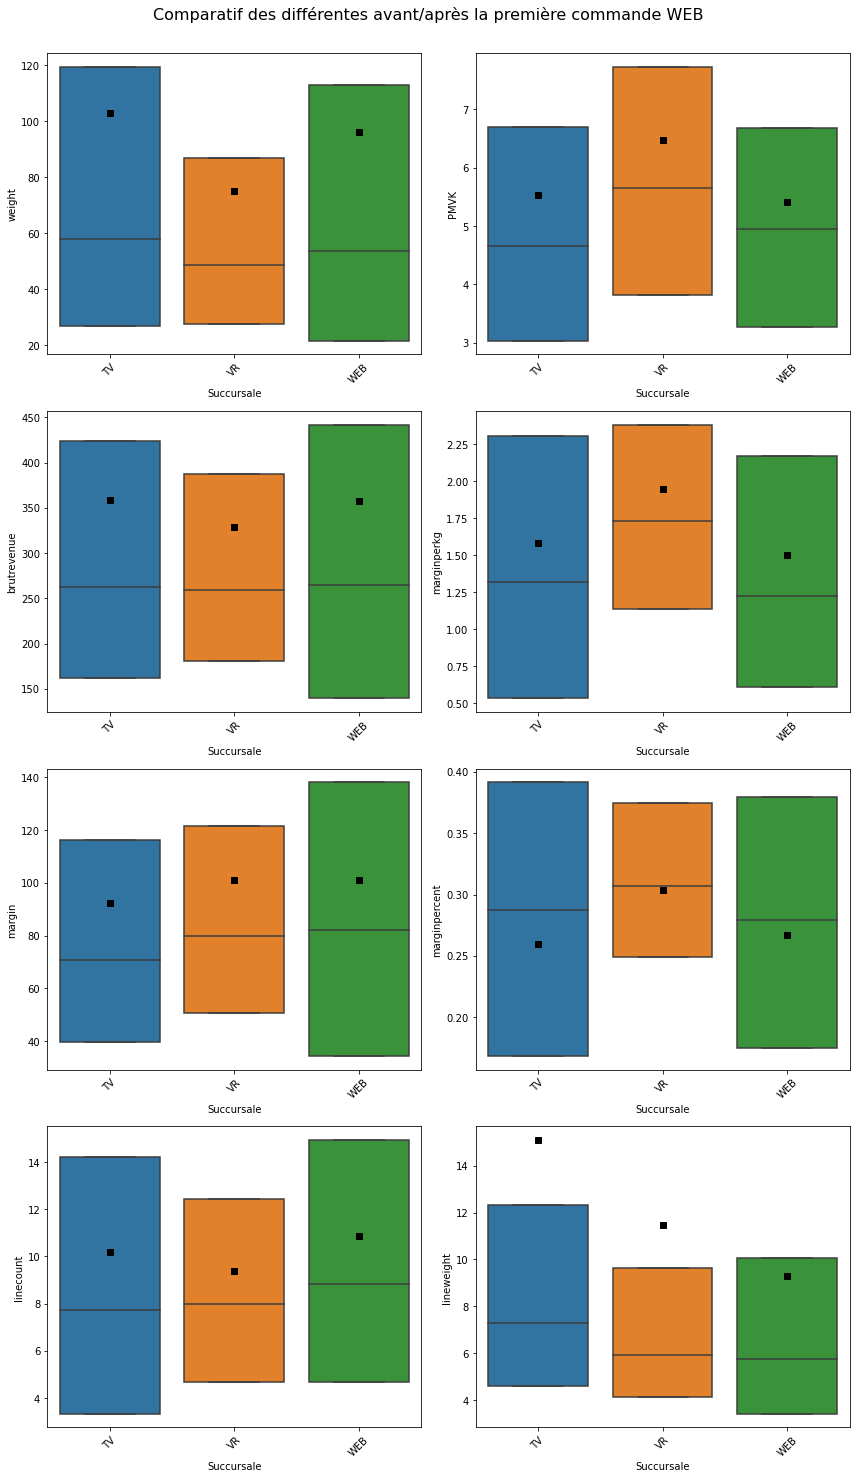

In [89]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

In [90]:
compute_distribution(data=status_updates,
                     indicators=['margin', 'weight'],
                     x='orgacom',
                     hue='new_stat',
                     percentile_selection=.99,
                     IQR_factor_selection=3.,
                     IQR_factor_plot=.5,
                    )

margin                                          \
orgacom                    1SOU                                           
new_stat                    EDI            TV           VR          WEB   
count               1564.000000   5202.000000  4082.000000  1397.000000   
mean                  66.017539     88.447238    93.907605    92.729859   
std                   65.825914    218.474373   104.592457    86.370588   
min                  -75.420000  -1085.470000  -215.930000   -26.007500   
1%                     2.356433    -12.189789     4.965400    -5.485615   
25%                   27.034896     37.430056    48.101215    35.550769   
50%                   48.186722     66.171722    74.251871    74.841750   
75%                   82.603124    108.142283   111.513196   124.750826   
99%                  334.706923    412.787490   369.423670   395.709332   
max                  797.931590  14473.235000  3707.830000   751.190645   
IQR                   55.568228     70.712227    63.411981    89.200056   
minimum_selection   -139.669789   -174.706624  -142.134728  -232.049400   
maximum_selection    249.307810    320.278963   301.749140   392.350995   
min_plot_selection  -139.669789   -174.706624  -142.134728  -232.049400   
max_plot_selection   334.706923    412.787490   369.423670   395.709332   
minimum_plot_range    -0.749218      2.073943    16.395225    -9.049259   
maximum_plot_range   110.387239    143.498396   143.219187   169.350854   

                                                                        \
orgacom                    1ALO                                          
new_stat                    EDI           TV           VR          WEB   
count               1058.000000  4143.000000  2659.000000  1196.000000   
mean                  71.631573    81.772914    93.424392    97.179068   
std                  117.493673   108.772024    92.405750   108.207226   
min                   -9.692671 -2387.110000  -267.620000   -45.222778   
1%                     4.998916   -28.691600     3.382300   -16.442891   
25%                   33.491582    33.453362    45.180705    15.301646   
50%                   53.908025    62.634891    71.080000    71.339091   
75%                   85.613314   108.260277   113.269035   139.056328   
99%                  281.497085   386.258237   410.893251   507.332548   
max                 3408.550000  3334.533333  1902.180000   811.530000   
IQR                   52.121732    74.806915    68.088330   123.754681   
minimum_selection   -122.873612  -190.967383  -159.084285  -355.962398   
maximum_selection    241.978508   332.681022   317.534025   510.320372   
min_plot_selection  -122.873612  -190.967383  -159.084285  -355.962398   
max_plot_selection   281.497085   386.258237   410.893251   510.320372   
minimum_plot_range     7.430717    -3.950095    11.136540   -46.575694   
maximum_plot_range   111.674180   145.663735   147.313200   200.933669   

                                              ...       weight               \
orgacom                   1LRO                ...         1ALO                
new_stat                   EDI            TV  ...           VR          WEB   
count               433.000000   2950.000000  ...  2659.000000  1196.000000   
mean                 52.220076     89.117826  ...    56.475991    93.039765   
std                  39.330893    218.016110  ...    71.735054   165.310565   
min                  -6.840000   -869.730000  ...     0.775800     0.640000   
1%                    3.787801     -1.799076  ...     4.408570     2.875733   
25%                  27.659969     36.674184  ...    23.947288    13.542429   
50%                  44.205769     65.430396  ...    40.210357    40.179503   
75%                  65.344835    106.232498  ...    67.851408    89.112247   
99%                 189.731323    414.096287  ...   268.931025   829.642890   
max                 347.180638  10279.682500  ...  2000.000000  1989.641760   
IQR             

In [91]:
show_mean = {
    'weight': True,
    'brutrevenue': True,
    'margin': True,
    'linecount': True,
    'PMVK': False,
    'marginperkg': False,
    'marginpercent': False,
    'lineweight': False,    
    'weight_clt_zscore': True,
    'brutrevenue_clt_zscore': True,
    'margin_clt_zscore': True,
    'linecount_clt_zscore': True,
    'PMVK_clt_zscore': False,
    'marginperkg_clt_zscore': False,
    'marginpercent_clt_zscore': False,
    'lineweight_clt_zscore': False,        
}

In [92]:
libs = {
    'weight': 'Poids (kg)',
    'brutrevenue': 'CA brut (€)',
    'margin': 'Marge en valeur (€)',
    'linecount': 'Nombre de lignes à la commande',
    'PMVK': 'PMVK (€/kg)',
    'marginperkg': 'Marge au kilo (€/kg)',
    'marginpercent': 'Marge pourcent (%)',
    'lineweight': 'Poids moyen de la ligne (kg)',    
    'weight_clt_zscore': 'Poids - zscore',
    'brutrevenue_clt_zscore': 'CA brut - zscore',
    'margin_clt_zscore': 'Marge en valeur - zscore',
    'linecount_clt_zscore': 'Nombre de lignes à la commande - zscore',
    'PMVK_clt_zscore': 'PMVK - zscore',
    'marginperkg_clt_zscore': 'Marge au kilo - zscore',
    'marginpercent_clt_zscore': 'Marge pourcent - zscore',
    'lineweight_clt_zscore': 'Poids moyen de la ligne - zscore',   
}

In [93]:
orders.columns

Index(['margin', 'brutrevenue', 'weight', 'linecount', 'origin2', 'seg1',
       'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4', 'PMVK', 'marginperkg',
       'marginpercent', 'lineweight', 'weight_clt_zscore',
       'brutrevenue_clt_zscore', 'margin_clt_zscore', 'linecount_clt_zscore',
       'PMVK_clt_zscore', 'marginperkg_clt_zscore', 'marginpercent_clt_zscore',
       'lineweight_clt_zscore', 'clt_stat'],
      dtype='object')

In [94]:
with pd.option_context('display.max_columns', None):
    display(orders.reset_index().loc[lambda x: x.orgacom == '2BRE'].sort_values('PMVK', ascending=False))

orgacom      client       date   margin  brutrevenue    weight  \
2390039    2BRE  0000161657 2020-08-18    38.28       119.00     0.020   
2311763    2BRE  0000083904 2020-01-28    37.99       169.02     0.030   
2288441    2BRE  0000116734 2017-12-06     5.42        53.10     0.010   
2092431    2BRE  0000102815 2018-04-09     1.41        15.08     0.004   
2412028    2BRE  0000165185 2018-12-07    27.01       124.61     0.090   
...         ...         ...        ...      ...          ...       ...   
2418200    2BRE  0000238884 2019-05-14 -1614.18       104.95  1487.974   
2418202    2BRE  0000238884 2019-11-07 -1665.47       102.38  1459.093   
2418203    2BRE  0000238884 2020-01-23 -3820.80       103.10  1800.662   
2418205    2BRE  0000238884 2020-06-12 -2506.47       107.85  2160.947   
2322452    2BRE  0000082099 2017-11-16    -8.33         0.01     1.200   

         linecount origin2 seg1 seg2 seg3 seg4 cat sscat  hier4         PMVK  \
2390039          1      VR   Z3   Z5   ZK   ZG  ZU   Z39    NaN  5950.000000   
2311763          1      VR   Z3   Z5   ZK   ZG  ZS    ZK    NaN  5634.000000   
2288441          1      TV   Z3   Z4   ZI   ZB  ZM   Z16  10897  5310.000000   
2092431          1      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10506  3770.000000   
2412028          1     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10337  1384.555556   
...            ...     ...  ...  ...  ...  ...  ..   ...    ...          ...   
2418200        106      TV   Z1   Z1   ZC   ZR  ZD   Z32    NaN     0.070532   
2418202        138      TV   Z1   Z1   ZC   ZR  ZD   Z32    NaN     0.070167   
2418203        166      TV   Z1   Z1   ZC   ZR  ZD   Z32    NaN     0.057257   
2418205        206      TV   Z1   Z1   ZC   ZR  ZD   Z32    NaN     0.049909   
2322452          1      TV   Z4   Z0   ZQ   ZO  Z5   Z27    NaN     0.008333   

         marginperkg  marginpercent  lineweight  weight_clt_zscore  \
2390039  1914.000000       0.321681    0.020000          -3.404922   
2311763  1266.333333       0.224766    0.030000          -1.334853   
2288441   542.000000       0.102072    0.010000          -0.607714   
2092431   352.500000       0.093501    0.004000          -1.932589   
2412028   300.111111       0.216756    0.090000          -1.792969   
...              ...            ...         ...                ...   
2418200    -1.084817     -15.380467   14.037491           0.314711   
2418202    -1.141442     -16.267533   10.573138           0.253891   
2418203    -2.121886     -37.059166   10.847361           0.973194   
2418205    -1.159894     -23.240334   10.490034           1.731910   
2322452    -6.941667    -833.000000    1.200000          -0.975103   

         brutrevenue_clt_zscore  margin_clt_zscore  linecount_clt_zscore  \
2390039               -1.886787          -2.038262             -3.288843   
2311763               -0.651247          -0.744334             -1.552904   
2288441               -0.858511          -1.018829             -0.794866   
2092431               -1.870758          -1.651300             -1.976682   
2412028               -1.851960          -1.279396             -1.736544   
...                         ...                ...                   ...   
2418200               -0.339103           0.404663             -0.318588   
2418202               -0.363617           0.372598              0.308785   
2418203               -0.356749          -0.974830              0.857737   
2418205               -0.311442          -0.153162              1.641954   
2322452               -0.702619          -0.647653             -0.339447   

         PMVK_clt_zscore  marginperkg_clt_zscore  marginpercent_clt_zscore  \
2390039         9.695882                9.695855                 -1.494979   
2311763         8.426335                8.425238                 -0.869890   
2288441        10.165559                9.223848                 -2.045462   
2092431        10.392715               10.392606                 -1.174687   
2412028       

In [95]:
status_updates.reset_index().loc[lambda x: x.orgacom == '2BRE'].sort_values('PMVK', ascending=False)

orgacom      client       date new_stat       margin  brutrevenue  \
27775    2BRE  0000041098 2020-07-13       TV    30.040000    169.24000   
28952    2BRE  0000073233 2020-07-09       TV    30.040000    169.24000   
28706    2BRE  0000072436 2020-07-16       TV    20.030000    112.82000   
36467    2BRE  0000283951 2020-07-27       VR     5.240000    149.40000   
36596    2BRE  0003012031 2018-12-03       VR    21.960000     99.00000   
...       ...         ...        ...      ...          ...          ...   
32904    2BRE  0000177371 2017-09-05       TV     5.003333     44.03500   
32898    2BRE  0000177357 2017-09-05       TV     5.160000     45.41000   
32902    2BRE  0000177368 2017-09-05       TV     1.813333     15.99500   
29397    2BRE  0000075408 2017-11-03       TV    33.535000    166.82500   
35042    2BRE  0000238884 2018-12-20       TV -2261.473750    140.50125   

            weight  linecount  ordercount        PMVK  ...  marginpercent  \
27775     0.516000       1.00           1  327.984496  ...       0.177499   
28952     0.516000       1.00           1  327.984496  ...       0.177499   
28706     0.344000       1.00           1  327.965116  ...       0.177539   
36467     0.720000       1.00           1  207.500000  ...       0.035074   
36596     0.500000       1.00           1  198.000000  ...       0.221818   
...            ...        ...         ...         ...  ...            ...   
32904   384.000000       1.00           6    0.114674  ...       0.113622   
32898   396.000000       1.00           6    0.114672  ...       0.113631   
32902   139.500000       1.00           6    0.114659  ...       0.113369   
29397  1512.000000       1.00           2    0.110334  ...       0.201019   
35042  1338.529875     122.25           8    0.104967  ...     -16.095755   

       lineweight  weight_clt_zscore  brutrevenue_clt_zscore  \
27775     0.51600                0.0                     0.0   
28952     0.51600                0.0                     0.0   
28706     0.34400                0.0                     0.0   
36467     0.72000                0.0                     0.0   
36596     0.50000                0.0                     0.0   
...           ...                ...                     ...   
32904   384.00000                0.0                     0.0   
32898   396.00000                0.0                     0.0   
32902   139.50000                0.0                     0.0   
29397  1512.00000                0.0                     0.0   
35042    10.94912                0.0                     0.0   

       margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
27775                0.0                   0.0              0.0   
28952                0.0                   0.0              0.0   
28706                0.0                   0.0              0.0   
36467                0.0                   0.0              0.0   
36596                0.0                   0.0              0.0   
...                  ...                   ...              ...   
32904                0.0                   0.0              0.0   
32898                0.0                   0.0              0.0   
32902                0.0                   0.0              0.0   
29397                0.0                   0.0              0.0   
35042                0.0                   0.0              0.0   

       marginperkg_clt_zscore  marginpercent_clt_zscore  lineweight_clt_zscore  
27775                     0.0                       0.0                    0.0  
28952                     0.0                       0.0                    0.0  
28706                     0.0                       0.0                    0.0  
36467                     0.0                       0.0                    0.0  
36596                     0.0                       0.0                    0.0  
...                       ...                       ...                    ...  
32904                     0.0          

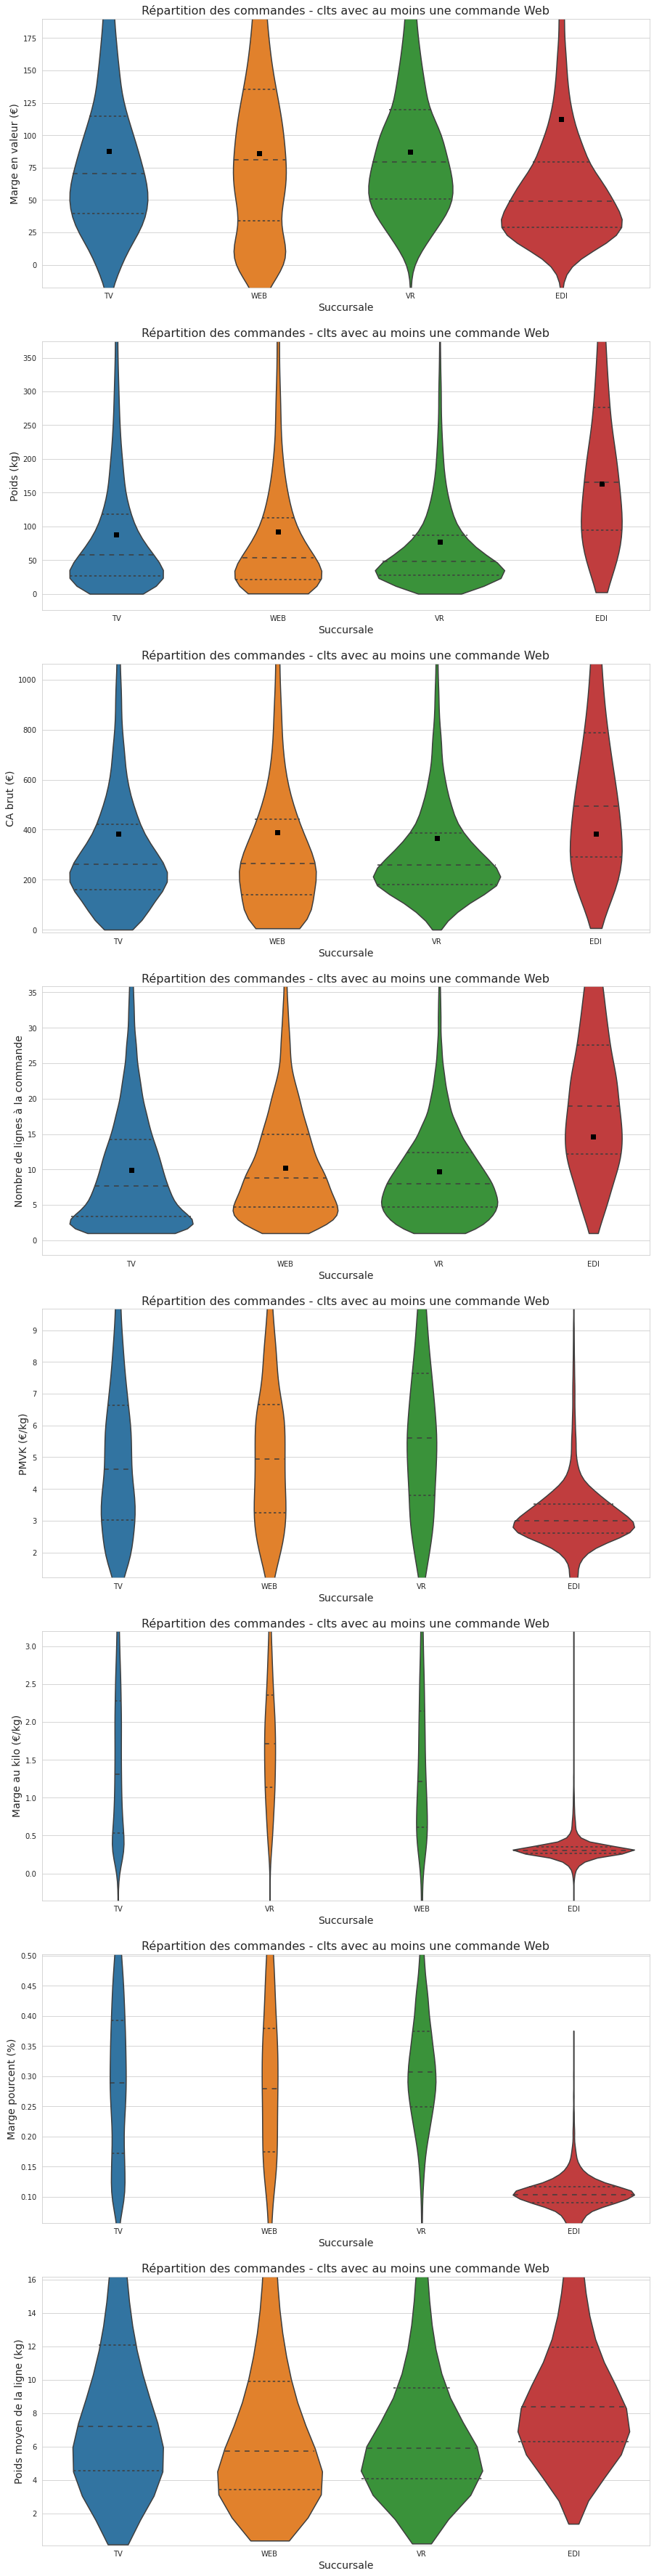

In [96]:
sns.set_style(style="whitegrid")

indicators = ['margin', 'weight', 'brutrevenue', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
# indicators = ['weight', 'brutrevenue']
x = 'new_stat'
hue = None #'new_stat'
fig, axs = plt.subplots(nrows=len(indicators), figsize=(15 , 8* len(indicators)), )
stats = compute_distribution(data=status_updates,
                             indicators=indicators,
                             x=x,
                             hue=hue,
                             percentile_selection=.99,
                             IQR_factor_selection=2.,
                             IQR_factor_plot=.5,
                            )
plot_ranges = stats.T.groupby(level=0, axis=0).agg({'min_plot_selection': 'min',
                                                    'max_plot_selection': 'max',
                                                    'minimum_plot_range': 'min',
                                                    'maximum_plot_range': 'max',
                                                   })
reset = status_updates.reset_index()
for i, indicator in enumerate(indicators):
    sns.violinplot(data=(reset.loc[(reset[indicator] >= plot_ranges.loc[indicator, 'min_plot_selection']) &
                                   (reset[indicator] <= plot_ranges.loc[indicator, 'max_plot_selection'])
                                  ]),
                   y=indicator,
                   x=x,
                   cut=0.,
                   hue=hue,
#                    scale='count',
                   inner='quartile',
                   ax=axs[i])
    axs[i].set_ylim(plot_ranges.loc[indicator, 'minimum_plot_range'],
                    plot_ranges.loc[indicator, 'maximum_plot_range'])
    if show_mean[indicator] and not hue:
        axs[i].scatter(x=[0, 1, 2, 3], y=[reset[['orgacom', indicator]].groupby('orgacom').mean()], marker='s', color='k')
    axs[i].set_ylabel(libs[indicator], fontsize=14)
    axs[i].set_xlabel('Succursale', fontsize=14)
    axs[i].set_title('Répartition des commandes - clts avec au moins une commande Web', fontsize=16)
#     ax.set_xticks([])
#     axs[i].grid(linestyle='--')

In [97]:
orders.groupby('origin2')['margin_clt_zscore'].describe().style.format('{:.3f}')

In [98]:
filter_otacos = (orders.hier4 != '198863')

In [99]:
orders = compute_zscores(orders, grouper_fields=['orgacom', 'client'], indicators=indicators)

margin done!
weight done!
brutrevenue done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


In [100]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444326 entries, ('1SOU', '0000065940', Timestamp('2017-07-03 00:00:00')) to ('2BRE', '0000284735', Timestamp('2020-08-31 00:00:00'))
Data columns (total 25 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   margin                    float64 
 1   brutrevenue               float64 
 2   weight                    float64 
 3   linecount                 int64   
 4   origin2                   object  
 5   seg1                      category
 6   seg2                      category
 7   seg3                      category
 8   seg4                      category
 9   cat                       category
 10  sscat                     category
 11  hier4                     object  
 12  PMVK                      float64 
 13  marginperkg               float64 
 14  marginpercent             float64 
 15  lineweight                float64 
 16  weight_clt_zscore         float64 
 17  brutrevenue_clt_zs

In [151]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

(-10000.0, 10000.0)

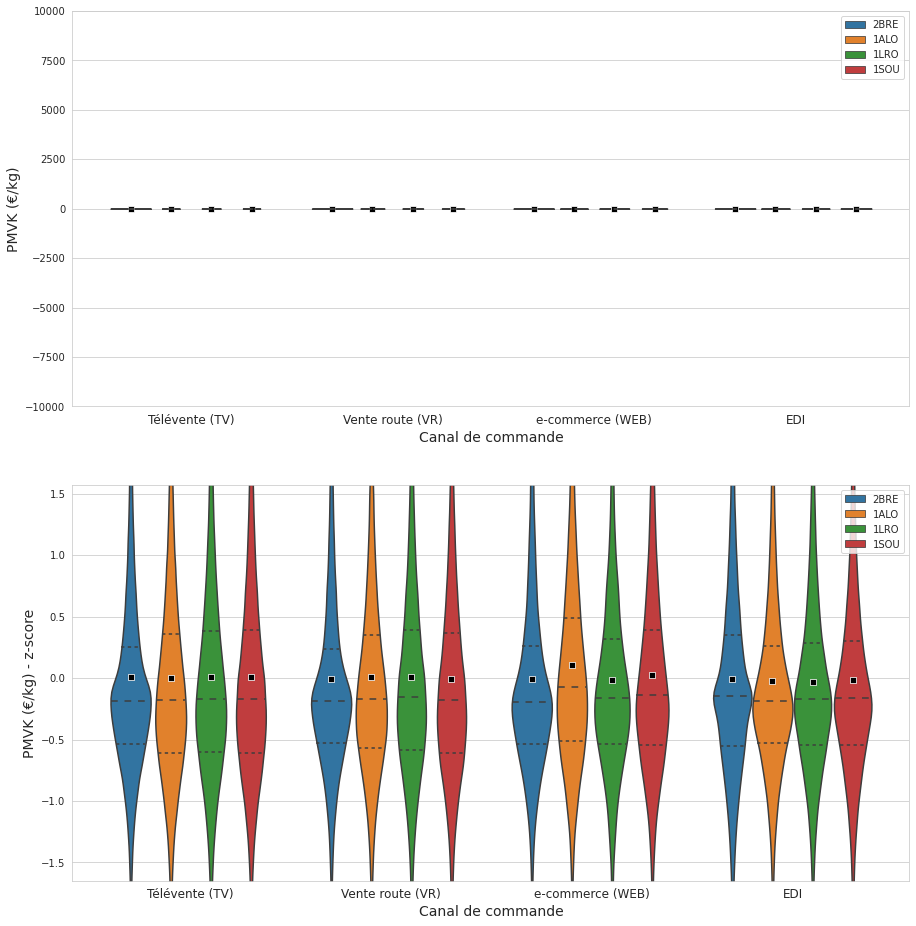

In [153]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              hue='orgacom', #'origin2', 
                              hue_order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='violin',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                             )

Text(0.5, 1.025, 'Comparatif des différentes avant/après la première commande WEB')

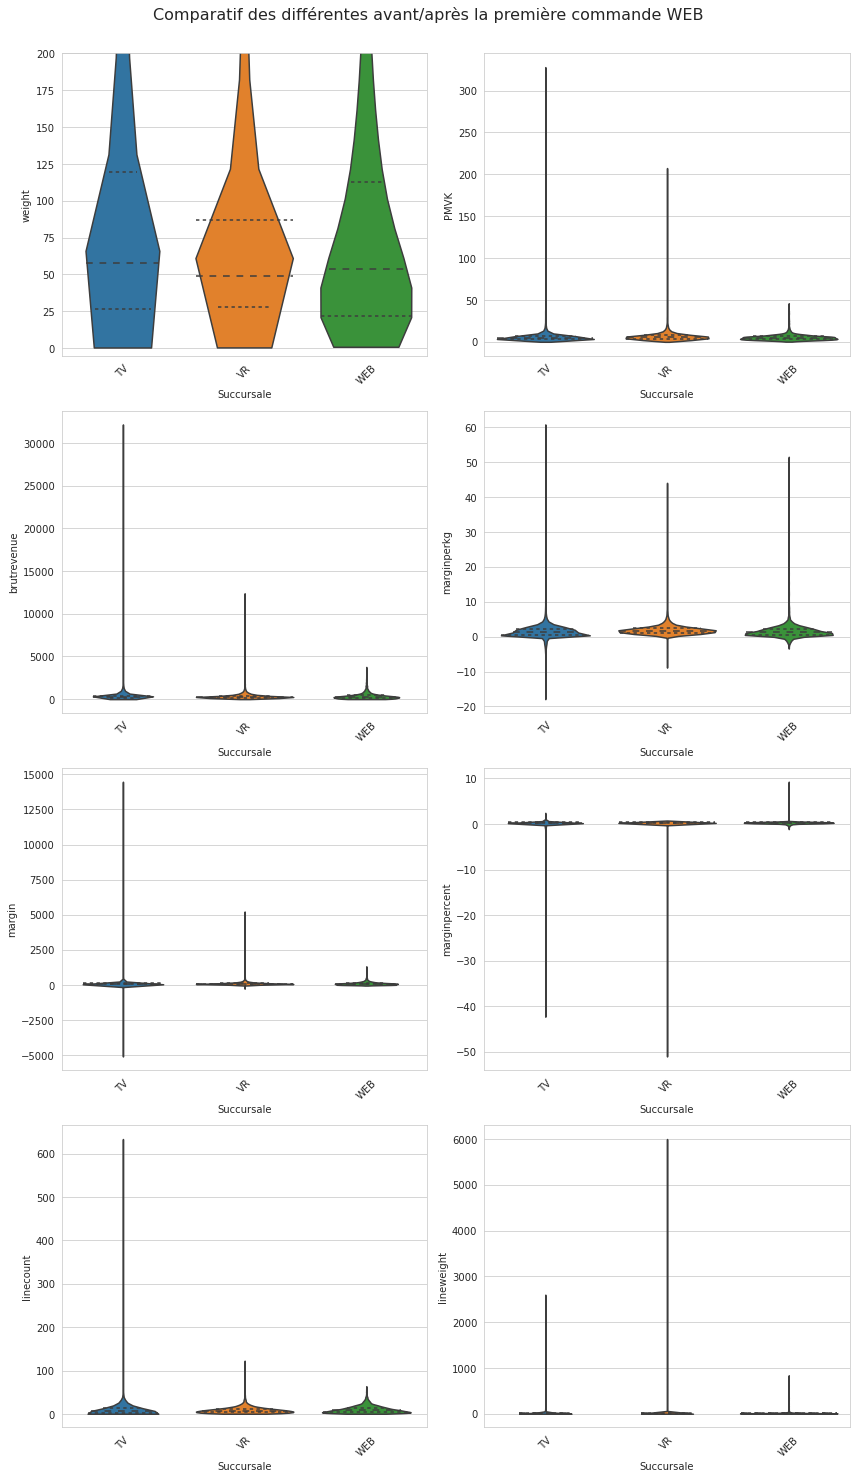

In [102]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.violinplot(data=status_updates.loc[:].reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                cut=0.,
#                 scale='count', 
                
                inner='quartile',   
                showfliers=False,
                
                whis=0.,
                **boxplot_args,
               )

#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
axs[0, 0].set_ylim(-5, 200)
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

Text(0.5, 1.025, 'Comparatif des différentes avant/après la première commande WEB')

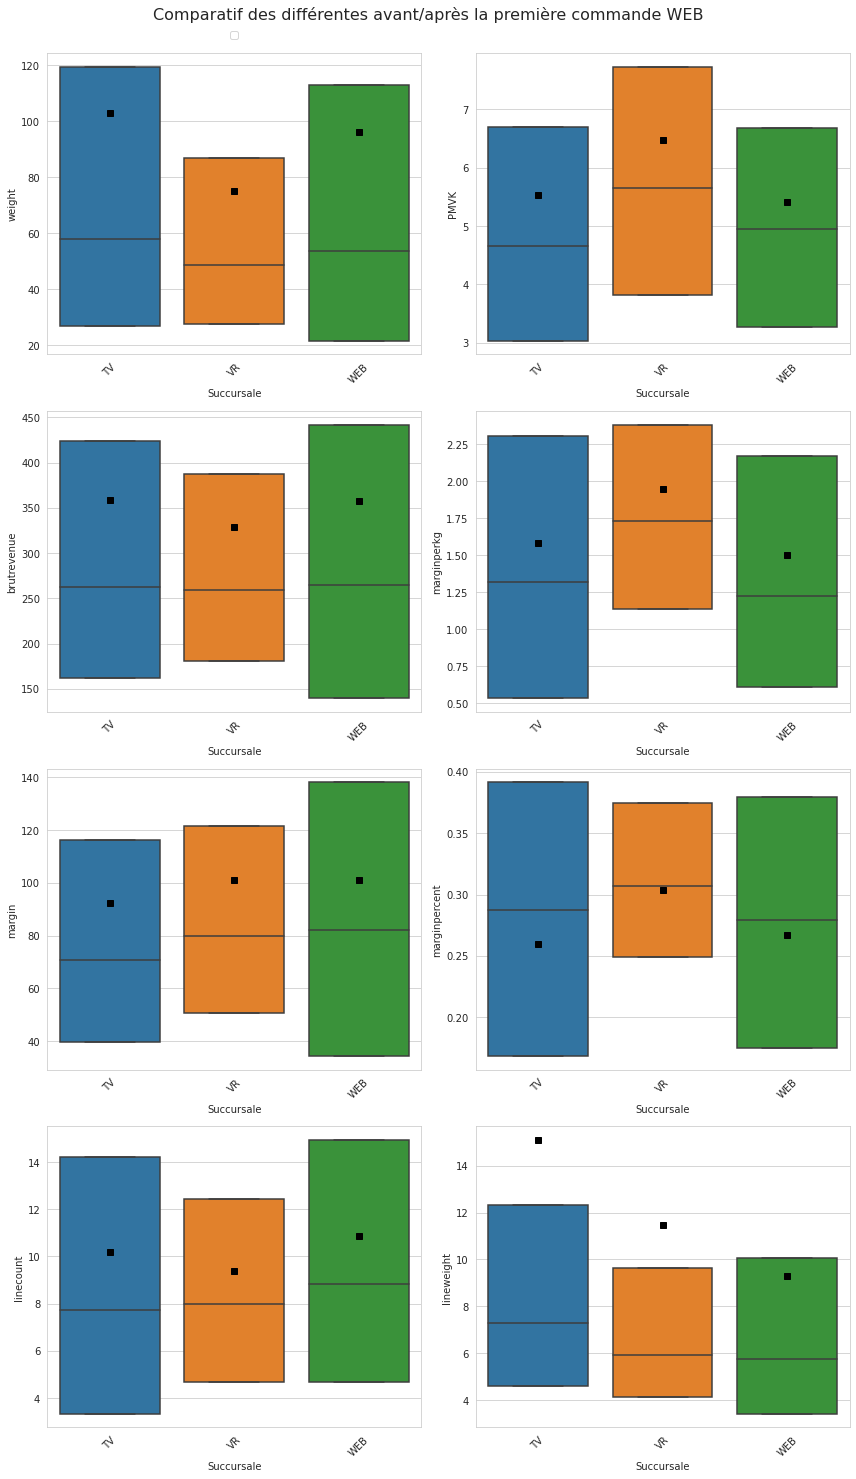

In [103]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=status_updates.reset_index(),
                y=indicator,
                x='new_stat',
                order=['TV', 'VR', 'WEB'],
#                 order=['ZK', 'ZL', 'ZI'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB', fontsize=16, y=1.025)

Text(0.5, 1.025, 'Comparatif des différentes avant/après la première commande WEB - zscore')

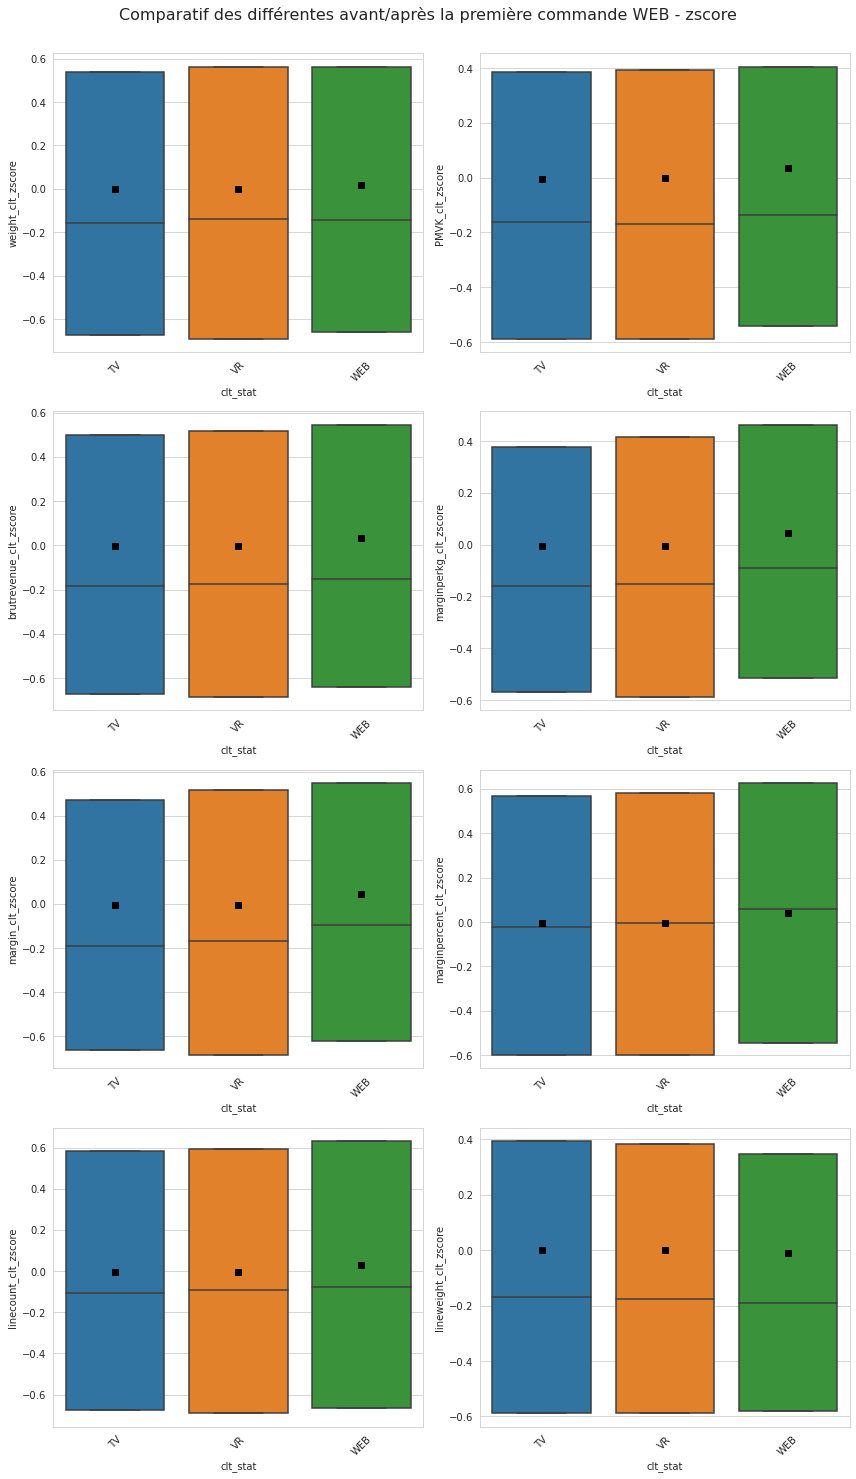

In [104]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='clt_stat',
                order=['TV', 'VR', 'WEB'],
#                 hue='new_stat',
#                 hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
#     axs[x, y].get_legend().remove()
#     axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

Text(0.5, 1.025, 'Comparatif des différentes avant/après la première commande WEB - zscore')

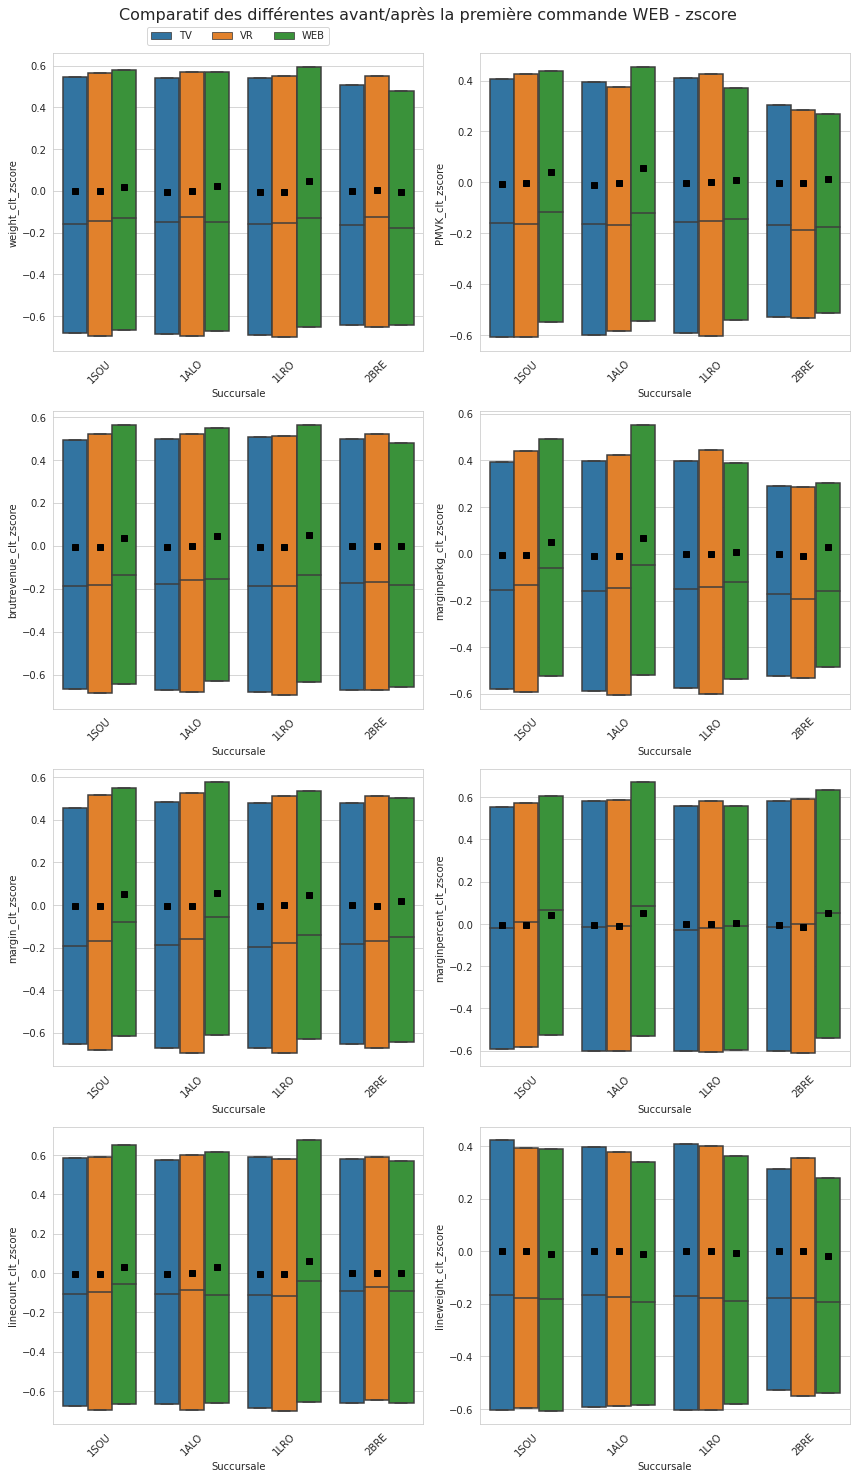

In [105]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.reset_index(),
                y=indicator + '_clt_zscore',
                x='orgacom',
#                 order=['TV', 'VR', 'WEB'],
                hue='clt_stat',
                hue_order=['TV', 'VR', 'WEB'],
                ax=axs[x, y],
                showfliers=False,
                whis=0.,
                **boxplot_args,
               )
    axs[x, y].get_legend().remove()
    axs[x, y].set_xlabel('Succursale')
#     axs[x, y].set_xticklabels([
#                                'ZK - Restau Com. Indépendante', 
#                                'ZL - Restau Com. Structurée',
#                                'ZI - Restau Coll. Autogérée',                               
#                                'ZJ - Restau Coll. Concédée',
#                               ])
    axs[x, y].xaxis.set_tick_params(rotation=45.)
fig.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
fig.suptitle('Comparatif des différentes avant/après la première commande WEB - zscore', fontsize=16, y=1.025)

## Plot des détails

In [106]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

margin  brutrevenue   weight  linecount origin2 seg1 seg2  \
orgacom date                                                                    
1ALO    2017-07-05   40.75       277.96   74.280          8      VR   Z3   Z4   
        2017-07-07   21.78       118.19   44.674          5      TV   Z3   Z4   
        2017-07-21   37.21       160.24   71.890          8      VR   Z3   Z4   
        2017-07-28  112.07       458.09   63.622          3      VR   Z3   Z4   
        2017-08-02   59.98       228.31   57.690          7      TV   Z3   Z4   
...                    ...          ...      ...        ...     ...  ...  ...   
        2020-08-10   26.55       122.59   20.400          4      TV   Z3   Z4   
        2020-08-14   95.33       325.25  116.594         15     WEB   Z3   Z4   
        2020-08-21   67.03       294.03   60.499         12      VR   Z3   Z4   
        2020-08-24    9.78        57.08    8.430          6     WEB   Z3   Z4   
        2020-08-28  209.28       712.54  292.463         22     WEB   Z3   Z4   

                   seg3 seg4 cat  ... weight_clt_zscore  \
orgacom date                      ...                     
1ALO    2017-07-05   ZI   ZD  ZP  ...          0.297741   
        2017-07-07   ZI   ZD  ZP  ...         -0.420514   
        2017-07-21   ZI   ZD  ZP  ...          0.239759   
        2017-07-28   ZI   ZD  ZP  ...          0.039173   
        2017-08-02   ZI   ZD  ZP  ...         -0.104740   
...                 ...  ...  ..  ...               ...   
        2020-08-10   ZI   ZD  ZP  ...         -1.009412   
        2020-08-14   ZI   ZD  ZP  ...          1.324299   
        2020-08-21   ZI   ZD  ZP  ...         -0.036592   
        2020-08-24   ZI   ZD  ZP  ...         -1.299810   
        2020-08-28   ZI   ZD  ZP  ...          5.590962   

                   brutrevenue_clt_zscore  margin_clt_zscore  \
orgacom date                                                   
1ALO    2017-07-05               0.125732          -0.501258   
        2017-07-07              -0.808261          -0.949642   
        2017-07-21              -0.562443          -0.584931   
        2017-07-28               1.178747           1.184493   
        2017-08-02              -0.164515          -0.046730   
...                                   ...                ...   
        2020-08-10              -0.782539          -0.836896   
        2020-08-14               0.402183           0.788819   
        2020-08-21               0.219675           0.119907   
        2020-08-24              -1.165501          -1.233279   
        2020-08-28               2.666226           3.482192   

                    linecount_clt_zscore  PMVK_clt_zscore  \
orgacom date                                                
1ALO    2017-07-05              0.204194        -0.386247   
        2017-07-07             -0.436232        -0.794441   
        2017-07-21              0.204194        -0.949555   
        2017-07-28             -0.863182         0.901171   
        2017-08-02             -0.009282        -0.306029   
...                                  ...              ...   
        2020-08-10             -0.649707         0.457825   
        2020-08-14              1.698520        -0.740837   
        2020-08-21              1.058095         0.029979   
        2020-08-24             -0.222757         0.741412   
        2020-08-28              3.192847        -0.872349   

                    marginperkg_clt_zscore  marginpercent_clt_zscore  \
orgacom date                                                           
1ALO    2017-07-05               -0.708051                 -1.165864   
        2017-07-07               -0.775405                 -0.723291   
        2017-07-21               -0.742246                 -0.160209   
        2017-07-28                0.629699                 -0.014171   
        2017-08-02               -0.166404                  0.198057   
...                                    ...                       ..

In [107]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

new_stat     margin  brutrevenue     weight  linecount  \
orgacom date                                                                
1ALO    2017-07-05       VR  58.903706   245.856084  59.780706   6.223776   
        2019-11-29      WEB  72.606341   293.409024  69.773220   9.902439   

                    ordercount      PMVK  marginperkg  marginpercent  \
orgacom date                                                           
1ALO    2017-07-05         143  4.112633     0.985330       0.239586   
        2019-11-29          41  4.205181     1.040605       0.247458   

                    lineweight  weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom date                                                                
1ALO    2017-07-05    9.605215          -0.707107               -0.707107   
        2019-11-29    7.046064           0.707107                0.707107   

                    margin_clt_zscore  linecount_clt_zscore  PMVK_clt_zscore  \
orgacom date                                                                   
1ALO    2017-07-05          -0.707107             -0.707107        -0.707107   
        2019-11-29           0.707107              0.707107         0.707107   

                    marginperkg_clt_zscore  marginpercent_clt_zscore  \
orgacom date                                                           
1ALO    2017-07-05               -0.707107                 -0.707107   
        2019-11-29                0.707107                  0.707107   

                    lineweight_clt_zscore  
orgacom date                               
1ALO    2017-07-05               0.707107  
        2019-11-29              -0.707107

In [108]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [109]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...   5.545864   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...  20.177857   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...   7.516667   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...   6.590990   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...   4.055793   

                              weight_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.530799               -0.420589   
                   2017-08-28         -0.480297               -0.376466   
                   2017-09-08         -0.580390               -0.508474   
                   2017-09-15         -0.237125               -0.113095   
                   2017-09-25          0.159954               -0.078432   
...                                         ...                     ...   
2BRE    0000282373 2020-08-31          0.000000                0.000000   
        0000283953 2020-08-31          0.000000                0.000000   
        0000284089 2020-08-31          0.000000                0.000000   
        0000284540 2020-08-31          0.000000                0.000000   
        0000284735 2020-08-31          0.000000                0.000000   

                               margin_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03          -0.515855              2.795673   
                   2017-08-28          -0.423595              3.252761   
                   2017-09-08          -0.610631             -0.403938   
                   2017-09-15          -0.033868              0.053150   
                   2017-09-25          -0.062385              0.967324   
...                                          ...                   ...   
2BRE    0000282373 2020-08-31           0.000000              0.000000   
        0000283953 2020-08-31           0.000000              0.000000   
        0000284089 2020-08-31           0.000000              0.000000   
        0000284540 2020-08-31           0.000000              0.000000   
        0000284735 2020-08-31           0.000000              0.000000   

                               PMVK_clt_zscore  marginperkg_clt_zscore  \
o

In [110]:
transco = lib_seg.loc[idx[2, : , :]].reset_index().set_index('code')['designation']
transco = dict()
for i in range(1, 7):
    transco['seg' + str(i)] = lib_seg.loc[idx[i, : , :]].reset_index().set_index('code')['designation']

transco['seg2']
    

code
Z0       Autres clientèles
Z1                     GMS
Z3     Commerce Spé. Proxi
Z4                  Social
Z5              Commercial
Z6    CVA (Circ Vte Alter)
Z7               Grossiste
Z8                  Export
Z9                  Groupe
Name: designation, dtype: object

In [111]:
orders.columns

Index(['margin', 'brutrevenue', 'weight', 'linecount', 'origin2', 'seg1',
       'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4', 'PMVK', 'marginperkg',
       'marginpercent', 'lineweight', 'weight_clt_zscore',
       'brutrevenue_clt_zscore', 'margin_clt_zscore', 'linecount_clt_zscore',
       'PMVK_clt_zscore', 'marginperkg_clt_zscore', 'marginpercent_clt_zscore',
       'lineweight_clt_zscore', 'clt_stat'],
      dtype='object')

In [112]:
origins = ['TV', 'VR', 'WEB', 'EDI']

In [113]:
def bkapp(doc, source_df=None, segs=['seg2', 'seg3'], filters=None, filters_exclude=None):

    # define controls
    # select: choose indicator from list
    indicator_map = {
        'Marge (€)': 'margin',
        'CA brut (€)': 'brutrevenue',
        'Tonnage (kg)': 'weight',
    }
    select = Select(title="Indicateur", options=list(indicator_map), value=list(indicator_map)[0])
    # datepickers : filter data on date
    min_date, max_date = date(2017, 7, 3), date(2020, 8, 30)
    datepickers = [
        DatePicker(title='Date de début', value=min_date, min_date=min_date, max_date=max_date),
        DatePicker(title='Date de fin', value=max_date, min_date=min_date, max_date=max_date),
    ]
    
    controls = [select, *datepickers,] 

    # compute data source
    def compute_indicator(df, indicator):
        temp = (
            df.groupby(['origin2'] + segs + ['orgacom'], observed=True,)[indicator]
               .sum()
               .unstack('origin2', fill_value=0.)
               .reindex(columns=origins)   
               .reset_index()
        )
        for seg in segs:
            temp[seg] = temp[seg].map(transco[seg])
        temp = temp.set_index(segs + ['orgacom'])
        return(temp)
        
    
    def select_data():
        date_range = [datepickers[0].value, datepickers[1].value] #dateslider.value
        selected = source_df.reset_index().loc[
            (orders.reset_index().date >= pd.to_datetime(date_range[0])) & #date.fromtimestamp(date_range[0] / 1000)
            (orders.reset_index().date <= pd.to_datetime(date_range[1])) #date.fromtimestamp(date_range[1] / 1000)
        ]        
        for attribute, filter_values in filters.items():        
            selected = selected.loc[
                selected[attribute].isin(filter_values)
            ]
        for attribute, filter_values in filters_exclude.items():
            selected = selected.loc[
                ~selected[attribute].isin(filter_values)
            ]
            
        return(selected)
    
    def update():
        indicator = indicator_map[select.value]
        df = select_data()
        grouped = compute_indicator(df, indicator)
        source.data = ColumnDataSource.from_df(grouped)

    for control in controls:
        control.on_change('value', lambda attr, old, new: update())

    df = compute_indicator(select_data(), indicator_map[select.value])
    source = ColumnDataSource(data=df)
    
    p = figure(x_range=FactorRange(*list(df.index)), plot_width=1000, )
    p.vbar_stack(df.columns,
                 x='_'.join(segs) + '_orgacom',
                 source=source,
                 width=.9,
                 color=list(mcolor.TABLEAU_COLORS.values())[:len(df.columns)],
                 legend_label=list(df.columns),
                )
    p.xaxis.major_label_orientation = 1
    p.yaxis.formatter = NumeralTickFormatter(format="0")

    doc.add_root(column(select, row(*datepickers), p)) #dateslider

In [115]:
show(partial(bkapp,
             source_df=orders,
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={'hier4': ['198863']},
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

In [ ]:
def bkapp(doc, source_df=None, segs=['seg2', 'seg3'], filters=None, filters_exclude=None):

    # define controls
    # select: choose indicator from list
    indicator_map = {
        'Marge (€)': 'margin',
        'CA brut (€)': 'brutrevenue',
        'Tonnage (kg)': 'weight',
    }
    select = Select(title="Indicateur", options=list(indicator_map), value=list(indicator_map)[0])
    # datepickers : filter data on date
    min_date, max_date = date(2017, 7, 3), date(2020, 8, 30)
    datepickers = [
        DatePicker(title='Date de début', value=min_date, min_date=min_date, max_date=max_date),
        DatePicker(title='Date de fin', value=max_date, min_date=min_date, max_date=max_date),
    ]
    
    controls = [select, *datepickers,] 

    # compute data source
    def compute_indicator(df, indicator):
        temp = (
            df.groupby(['origin2'] + segs + ['orgacom'], observed=True,)[indicator]
               .sum()
               .unstack('origin2', fill_value=0.)
               .reindex(columns=origins)   
               .reset_index()
        )
        for seg in segs:
            temp[seg] = temp[seg].map(transco[seg])
        temp = temp.set_index(segs + ['orgacom'])
        return(temp)
        
    
    def select_data():
        date_range = [datepickers[0].value, datepickers[1].value] #dateslider.value
        selected = source_df.reset_index().loc[
            (orders.reset_index().date >= pd.to_datetime(date_range[0])) & #date.fromtimestamp(date_range[0] / 1000)
            (orders.reset_index().date <= pd.to_datetime(date_range[1])) #date.fromtimestamp(date_range[1] / 1000)
        ]        
        for attribute, filter_values in filters.items():        
            selected = selected.loc[
                selected[attribute].isin(filter_values)
            ]
        for attribute, filter_values in filters_exclude.items():
            selected = selected.loc[
                ~selected[attribute].isin(filter_values)
            ]
            
        return(selected)
    
    def update():
        indicator = indicator_map[select.value]
        df = select_data()
        grouped = compute_indicator(df, indicator)
        source.data = ColumnDataSource.from_df(grouped)

    for control in controls:
        control.on_change('value', lambda attr, old, new: update())

    df = compute_indicator(select_data(), indicator_map[select.value])
    source = ColumnDataSource(data=df)
    
    p = figure(x_range=FactorRange(*list(df.index)), plot_width=1000, )
    p.vbar_stack(df.columns,
                 x='_'.join(segs) + '_orgacom',
                 source=source,
                 width=.9,
                 color=list(mcolor.TABLEAU_COLORS.values())[:len(df.columns)],
                 legend_label=list(df.columns),
                )
    p.xaxis.major_label_orientation = 1
    p.yaxis.formatter = NumeralTickFormatter(format="0")

    doc.add_root(column(select, row(*datepickers), p)) #dateslider

## Essai d'ajouter le choix de l'indicateur unitaire

In [ ]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Premier test', plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [ ]:
status_updates

In [ ]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates.reset_index(inplace=True)

In [ ]:
status_updates

In [ ]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [ ]:
status_updates.end_date - status_updates.date

In [ ]:
for indicator in indicators2:
    status_update[indicator] = 

In [ ]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)